# Pacotes úteis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore');

from statsmodels.tsa.seasonal import seasonal_decompose as stl
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.tree import DecisionTreeRegressor as dt
from itertools import product
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX as sr
from numpy import log
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
random.seed(12345)

from sklearn.metrics import r2_score


from sklearn.model_selection import cross_val_score as crv

from math import log

import statsmodels.api as sm

import seaborn as sns

# EDA



## Carregando o dataset

In [154]:
df = pd.read_excel("DadosBA.xlsx", sheet_name = None)
df = pd.concat([df['2018'],df['2019'],df['2020']]) # Concatenar data from 2018 and 2020 dataframes
# df = pd.concat([df['2020']]) # Concatenar data from 2018 and 2020 dataframes
df.set_index('Timestamp', inplace = True) #set timestamps as index



In [155]:
df.replace(to_replace='Bad',value=np.nan,inplace=True)
df.isna().any() # verifique se existem valores NAN (sequências 'Bad' substituídas)
df.interpolate(inplace=True)

df = df.dropna()

In [156]:
filtro = (df.index.year>=2018)
df = df[filtro]
filtro = (df.index.year<=2020)
df = df[filtro]
# filtro = (df.index.hour>=18)
# df = df[filtro]
# filtro = (df.index.hour<=21)
# df = df[filtro]

hora = '24h'

df.isna().any() # verifique se não há valores NAN
df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1',
                        'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2',
                        'BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3',
                        'BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01',
                        'BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA - FT01',
                        'BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02',
                        'BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03',
                        'BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01',
                        'BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})


In [164]:
df_horarios_pico = df2[(df.index.hour >= 18) & (df.index.hour <= 21)]
df_horarios_pico.describe().to_excel('estatistica.xlsx')

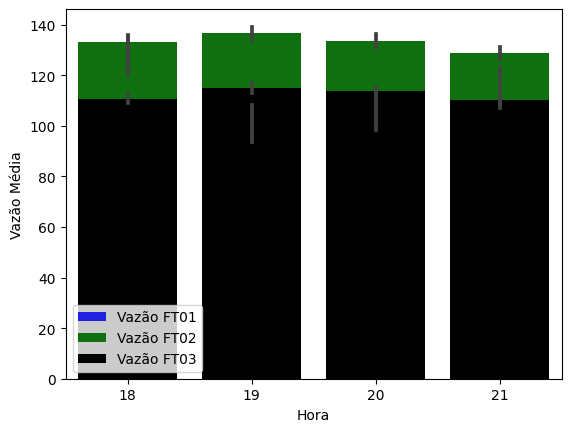

In [5]:


# Filtro para os horários de interesse (18h às 21h)
filtro = (df.index.hour >= 18) & (df.index.hour <= 21)
df_horarios_pico = df[filtro]

# Criar um gráfico de barras para mostrar a demanda média em cada hora
sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE ENTRADA - FT01'], color='blue', label='Vazão FT01')
sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'], color='green', label='Vazão FT02')
sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE RECALQUE - FT03'], color='black', label='Vazão FT03')

#plt.title('Vazão Média nos Horários de Pico')
plt.xlabel('Hora')
plt.ylabel('Vazão Média')
plt.legend()
plt.savefig('grafico-barras-demanda.pdf', format='pdf')
plt.show()



In [6]:
# Filtrar os horários de interesse (18h às 21h)
filtro_horarios = (df.index.hour >= 18) & (df.index.hour <= 21)
df_horarios_pico = df[filtro_horarios]

# Encontrar a data e hora do horário de maior demanda para cada variável
horario_maior_demanda_ft01 = df_horarios_pico['VAZÃO DE ENTRADA - FT01'].idxmax()
horario_maior_demanda_ft02 = df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'].idxmax()
horario_maior_demanda_ft03 = df_horarios_pico['VAZÃO DE RECALQUE - FT03'].idxmax()

print("Horário de maior demanda das 18h às 21h - VAZÃO DE ENTRADA- FT01:")
print(horario_maior_demanda_ft01)
print("Horário de maior demanda das 18h às 21h - VAZÃO DE GRAVIDADE - FT02:")
print(horario_maior_demanda_ft02)
print("Horário de maior demanda das 18h às 21h - VAZÃO DE RECALQUE - FT03:")
print(horario_maior_demanda_ft03)


Horário de maior demanda das 18h às 21h - VAZÃO DE ENTRADA- FT01:
2020-10-08 21:00:00
Horário de maior demanda das 18h às 21h - VAZÃO DE GRAVIDADE - FT02:
2020-10-20 18:00:00
Horário de maior demanda das 18h às 21h - VAZÃO DE RECALQUE - FT03:
2020-11-26 19:00:00


In [7]:
# Filtro para os horários de interesse (18h às 21h)
filtro_horarios = (df.index.hour >= 18) & (df.index.hour <= 21)
df_filtrado = df[filtro_horarios]

# Criação do DataFrame para armazenar os resultados
df_maior_demanda = pd.DataFrame(columns=['Variável', 'Horário de Maior Demanda', 'Valor da Demanda'])

# Variável VAZÃO DE ENTRADA - FT01
horario_maior_demanda_ft01 = df_filtrado[df_filtrado['VAZÃO DE ENTRADA - FT01'] == df_filtrado['VAZÃO DE ENTRADA - FT01'].max()].index[0]
demanda_maior_horario_ft01 = df_filtrado.loc[horario_maior_demanda_ft01, 'VAZÃO DE ENTRADA - FT01']
df_maior_demanda = df_maior_demanda.append({'Variável': 'VAZÃO DE ENTRADA - FT01',
                                            'Horário de Maior Demanda': horario_maior_demanda_ft01,
                                            'Valor da Demanda': demanda_maior_horario_ft01},
                                           ignore_index=True)

# Variável VAZÃO DE GRAVIDADE - FT02
horario_maior_demanda_ft02 = df_filtrado[df_filtrado['VAZÃO DE GRAVIDADE - FT02'] == df_filtrado['VAZÃO DE GRAVIDADE - FT02'].max()].index[0]
demanda_maior_horario_ft02 = df_filtrado.loc[horario_maior_demanda_ft02, 'VAZÃO DE GRAVIDADE - FT02']
df_maior_demanda = df_maior_demanda.append({'Variável': 'VAZÃO DE GRAVIDADE - FT02',
                                            'Horário de Maior Demanda': horario_maior_demanda_ft02,
                                            'Valor da Demanda': demanda_maior_horario_ft02},
                                           ignore_index=True)

# Variável VAZÃO DE RECALQUE - FT03
horario_maior_demanda_ft03 = df_filtrado[df_filtrado['VAZÃO DE RECALQUE - FT03'] == df_filtrado['VAZÃO DE RECALQUE - FT03'].max()].index[0]
demanda_maior_horario_ft03 = df_filtrado.loc[horario_maior_demanda_ft03, 'VAZÃO DE RECALQUE - FT03']
df_maior_demanda = df_maior_demanda.append({'Variável': 'VAZÃO DE RECALQUE - FT03',
                                            'Horário de Maior Demanda': horario_maior_demanda_ft03,
                                            'Valor da Demanda': demanda_maior_horario_ft03},
                                           ignore_index=True)

# Arredondar os valores para duas casas decimais
df_maior_demanda['Valor da Demanda'] = df_maior_demanda['Valor da Demanda'].round(2)

# Exibir o DataFrame com os resultados
print(df_maior_demanda)


                    Variável Horário de Maior Demanda  Valor da Demanda
0    VAZÃO DE ENTRADA - FT01      2020-10-08 21:00:00            383.87
1  VAZÃO DE GRAVIDADE - FT02      2020-10-20 18:00:00            326.17
2   VAZÃO DE RECALQUE - FT03      2020-11-26 19:00:00            194.35


In [8]:
df_maior_demanda.to_excel('maior_demanda.xlsx', index=False)

In [9]:
demanda_horario_pico = df.between_time('18:00:00', '21:00:00')['NIVEL DO RESERVATÓRIO - LT01'].max()
volume_minimo = demanda_horario_pico * 1.2 *1000

print(f"O volume mínimo de água necessário é de {volume_minimo:.2f} litros.")



O volume mínimo de água necessário é de 5285.90 litros.


In [10]:
# Calcular os percentis
pressao_percentil10 = round(df['PRESSÃO DE SUCÇÃO - PT01'].quantile(0.10), 2)
pressao_percentil90 = round(df['PRESSÃO DE SUCÇÃO - PT01'].quantile(0.90), 2)

# Imprimir os resultados
print("Pressão Percentil 10:", pressao_percentil10)
print("Pressão Percentil 90:", pressao_percentil90)


Pressão Percentil 10: 3.48
Pressão Percentil 90: 5.29


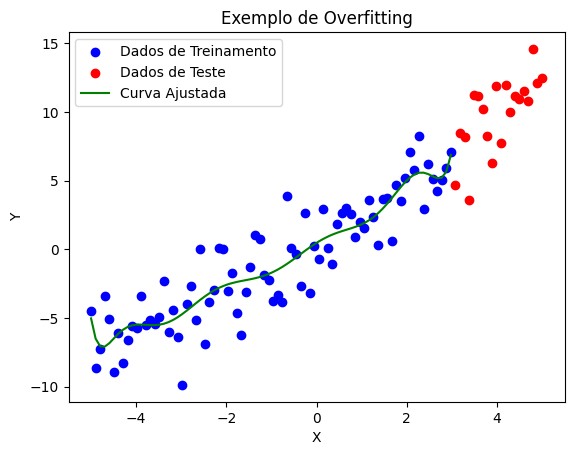

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Gerando dados de exemplo
np.random.seed(0)
x = np.linspace(-5, 5, 100)
y_true = 2 * x + 1 + np.random.normal(0, 2, 100)

# Adicionando ruído ao conjunto de treinamento
x_train = x[:80]
y_train = y_true[:80] + np.random.normal(0, 0.5, 80)

# Adicionando ruído ao conjunto de teste
x_test = x[80:]
y_test = y_true[80:] + np.random.normal(0, 0.5, 20)

# Ajustando um modelo polinomial de alta ordem
degree = 10
p = np.polyfit(x_train, y_train, degree)
y_train_pred = np.polyval(p, x_train)
y_test_pred = np.polyval(p, x_test)

# Plotando os dados e a curva ajustada
plt.scatter(x_train, y_train, color='blue', label='Dados de Treinamento')
plt.scatter(x_test, y_test, color='red', label='Dados de Teste')
plt.plot(x_train, y_train_pred, color='green', label='Curva Ajustada')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exemplo de Overfitting')
plt.show()


Erro quadrático médio (treinamento): 0.847678856420971
Erro quadrático médio (teste): 0.6536995137170021


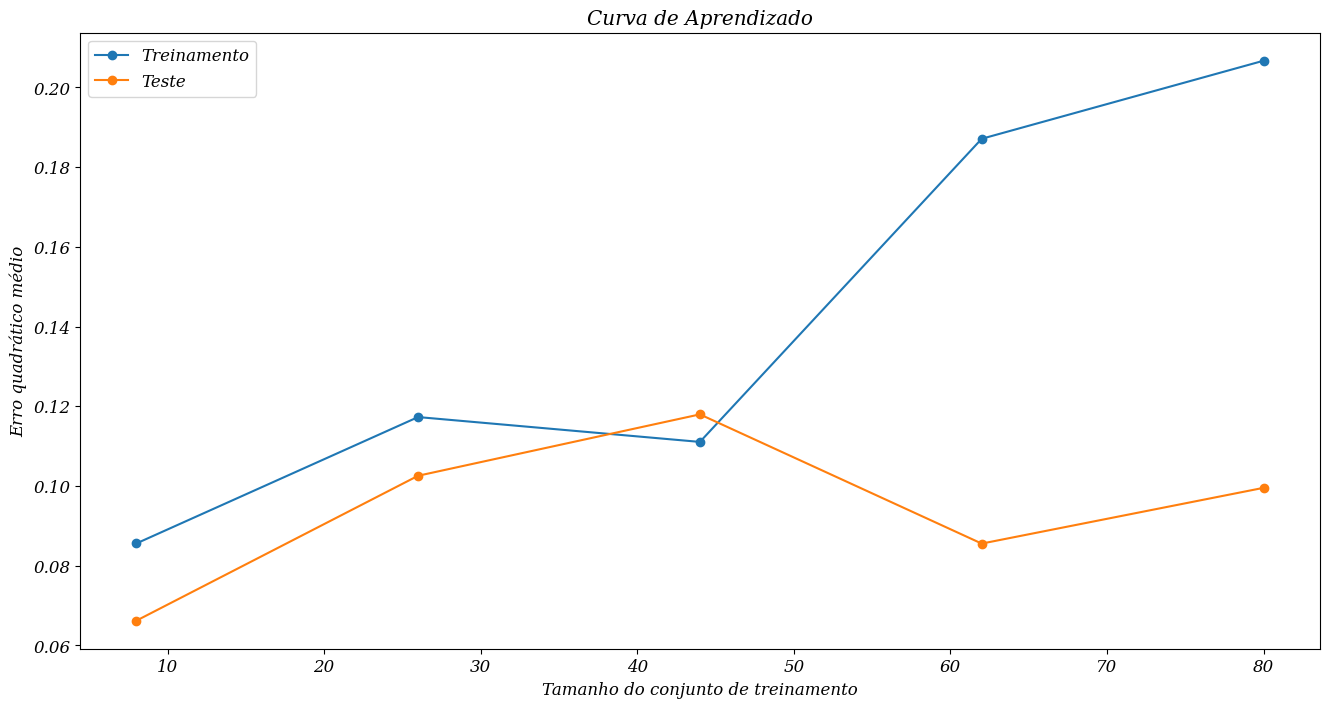

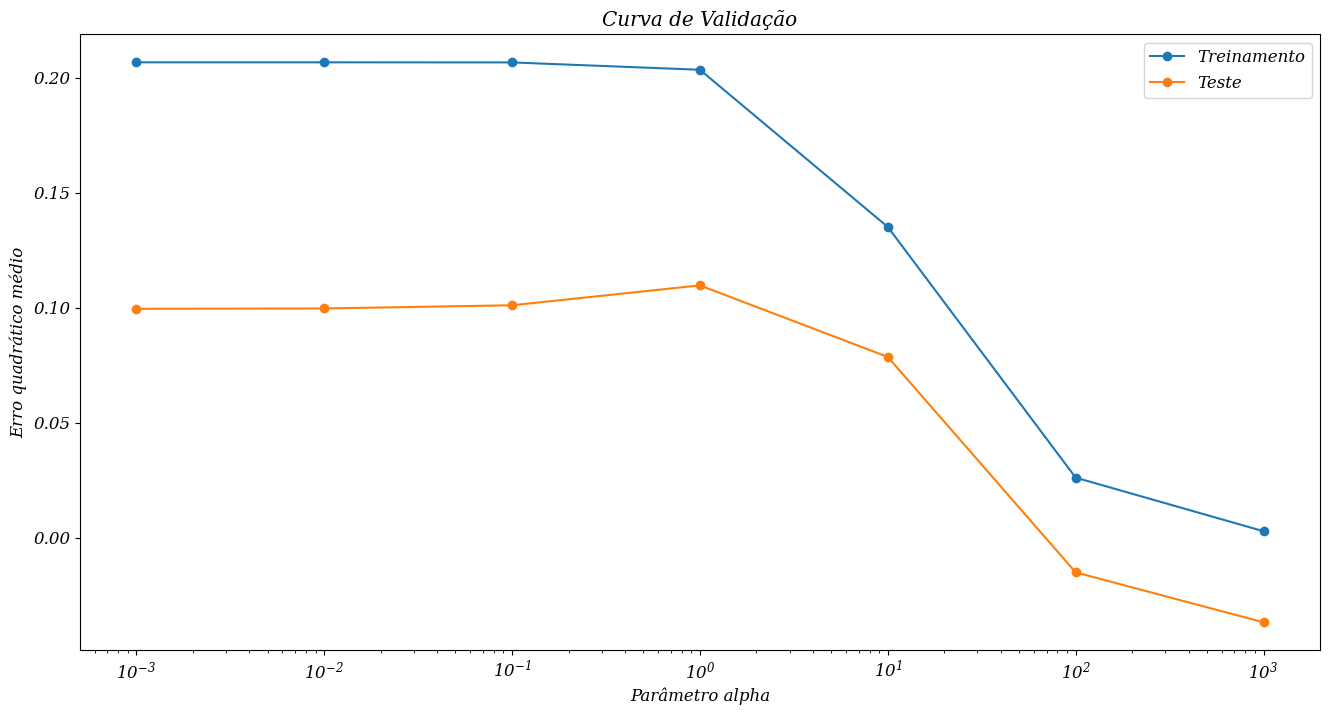

In [153]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Geração de dados de exemplo
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 * X.squeeze() + np.random.randn(100)

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento do modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Avaliação do modelo nos dados de treinamento
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Erro quadrático médio (treinamento):", train_mse)

# Avaliação do modelo nos dados de teste
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Erro quadrático médio (teste):", test_mse)

# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot da curva de aprendizado
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label='Treinamento')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Teste')
plt.xlabel('Tamanho do conjunto de treinamento')
plt.ylabel('Erro quadrático médio')
plt.legend(loc='best')
plt.title('Curva de Aprendizado')
plt.show()

# Curva de validação
param_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(Ridge(), X, y, param_name="alpha", param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot da curva de validação
plt.figure()
plt.plot(param_range, train_scores_mean, 'o-', label='Treinamento')
plt.plot(param_range, test_scores_mean, 'o-', label='Teste')
plt.xscale('log')
plt.xlabel('Parâmetro alpha')
plt.ylabel('Erro quadrático médio')
plt.legend(loc='best')
plt.title('Curva de Validação')
plt.show()


In [12]:
# Calcular os percentis
pressao_percentil10 = round(df['PRESSÃO DE RECALQUE - PT02'].quantile(0.10), 2)
pressao_percentil90 = round(df['PRESSÃO DE RECALQUE - PT02'].quantile(0.90), 2)

# Imprimir os resultados
print("Pressão Percentil 10:", pressao_percentil10)
print("Pressão Percentil 90:", pressao_percentil90)

Pressão Percentil 10: 15.82
Pressão Percentil 90: 24.02


In [13]:
print(df.columns)

Index(['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'NIVEL DO RESERVATÓRIO - LT01', 'VAZÃO DE ENTRADA - FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02'],
      dtype='object')


# Demanda diaria

In [14]:

# Definir as variáveis
nivel_reservatorio = df['NIVEL DO RESERVATÓRIO - LT01']
vazao_entrada = df['VAZÃO DE ENTRADA - FT01'] / 3600  # Converter para m³/s
vazao_gravidade = df['VAZÃO DE GRAVIDADE - FT02'] / 3600  # Converter para m³/s
vazao_recalque = df['VAZÃO DE RECALQUE - FT03'] / 3600  # Converter para m³/s

# Calcular a variação do nível do reservatório
variacao_nivel_reservatorio = vazao_entrada - vazao_gravidade - vazao_recalque

# Verificar o equilíbrio do nível do reservatório
equilibrio = variacao_nivel_reservatorio.mean() == 0

# Exibir o resultado
if equilibrio:
    print("O sistema está em equilíbrio.")
else:
    print("O sistema não está em equilíbrio.")


O sistema não está em equilíbrio.


In [15]:
vazao_entrada = df_maior_demanda.loc[df_maior_demanda['Variável'] == 'VAZÃO DE ENTRADA - FT01', 'Valor da Demanda'].values[0]
vazao_gravidade = df_maior_demanda.loc[df_maior_demanda['Variável'] == 'VAZÃO DE GRAVIDADE - FT02', 'Valor da Demanda'].values[0]
vazao_recalque = df_maior_demanda.loc[df_maior_demanda['Variável'] == 'VAZÃO DE RECALQUE - FT03', 'Valor da Demanda'].values[0]


In [16]:
demanda_diaria = 904.39


In [17]:
quantidade_agua_necessaria = demanda_diaria - vazao_entrada - vazao_gravidade - vazao_recalque


In [18]:
if quantidade_agua_necessaria == 0:
    print("Existe um equilíbrio entre a demanda diária e as vazões.")
else:
    print("Não existe um equilíbrio entre a demanda diária e as vazões.")


Não existe um equilíbrio entre a demanda diária e as vazões.


In [19]:

# Variáveis de vazão em litros por hora
vazao_entrada = 383.87
vazao_gravidade = 326.17
vazao_recalque = 194.35

# Demanda diária em litros
demanda_diaria = 5000

# Calcular a quantidade de água necessária para atender à demanda diária
quantidade_agua_necessaria = np.round(demanda_diaria - vazao_entrada - vazao_gravidade - vazao_recalque, 2)

# Imprimir o resultado
print(f"A quantidade de água necessária para atender à demanda diária é de {quantidade_agua_necessaria} litros.")


A quantidade de água necessária para atender à demanda diária é de 4095.61 litros.


In [20]:
# Variáveis de vazão em litros por hora
vazao_entrada = df['VAZÃO DE ENTRADA - FT01'].max()
vazao_gravidade = df['VAZÃO DE GRAVIDADE - FT02'].max()
vazao_recalque = df['VAZÃO DE RECALQUE - FT03'].max()

# Cálculo da demanda diária
demanda_diaria = df['VAZÃO DE ENTRADA - FT01'] + df['VAZÃO DE GRAVIDADE - FT02'] + df['VAZÃO DE RECALQUE - FT03']

# Soma total da demanda diária
demanda_total = demanda_diaria.sum()

# Calcular a quantidade de água necessária para atender à demanda diária
quantidade_agua_necessaria = demanda_total - vazao_entrada - vazao_gravidade - vazao_recalque

# Verificar se há equilíbrio entre as vazões e a demanda diária
if quantidade_agua_necessaria == 0:
    print("Existe equilíbrio entre as vazões e a demanda diária.")
elif quantidade_agua_necessaria > 0:
    print("Há um excesso de água, é possível reduzir as vazões para atingir o equilíbrio.")
else:
    print("Há uma deficiência de água, é necessário aumentar as vazões para atingir o equilíbrio.")


Há um excesso de água, é possível reduzir as vazões para atingir o equilíbrio.


In [21]:
# Calcular a soma das vazões por intervalo de tempo (por exemplo, a cada hora)
vazoes_por_intervalo = df[['VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03']].sum(axis=1)

# Definir a frequência dos dados (por exemplo, a cada hora)
frequencia = '1H'

# Resample dos dados para a frequência desejada (por exemplo, de hora em hora)
vazoes_resample = vazoes_por_intervalo.resample(frequencia).sum()

# Calcular a demanda diária somando as vazões
demandas_diarias = vazoes_resample.resample('D').sum()

# Imprimir as demandas diárias
print(demandas_diarias)


Timestamp
2018-01-01     8137.145294
2018-01-02     9104.172798
2018-01-03     9453.075214
2018-01-04     9435.461704
2018-01-05    10297.908028
                  ...     
2020-12-27    10498.914763
2020-12-28    11283.025036
2020-12-29    10440.954248
2020-12-30    10612.092546
2020-12-31    10735.596754
Freq: D, Length: 1096, dtype: float64


In [22]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Identificar os horários de maior demanda
horarios_maior_demanda = df_horarios_pico[df_horarios_pico['VAZÃO DE RECALQUE - FT03'] == df_horarios_pico['VAZÃO DE RECALQUE - FT03'].max()].index

# Exibir os horários de maior demanda
print("Horários de maior demanda das 18h às 21h:")
for horario in horarios_maior_demanda:
    print(horario)


Horários de maior demanda das 18h às 21h:
2020-11-26 19:00:00


In [23]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Identificar os horários de maior demanda
horarios_maior_demanda = df_horarios_pico[df_horarios_pico['VAZÃO DE ENTRADA - FT01'] == df_horarios_pico['VAZÃO DE ENTRADA - FT01'].max()].index

# Exibir os horários de maior demanda
print("Horários de maior demanda das 18h às 21h:")
for horario in horarios_maior_demanda:
    print(horario)


Horários de maior demanda das 18h às 21h:
2020-10-08 21:00:00


In [24]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Identificar os horários de maior demanda
horarios_maior_demanda = df_horarios_pico[df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'] == df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'].max()].index

# Exibir os horários de maior demanda
print("Horários de maior demanda das 18h às 21h:")
for horario in horarios_maior_demanda:
    print(horario)


Horários de maior demanda das 18h às 21h:
2020-10-20 18:00:00


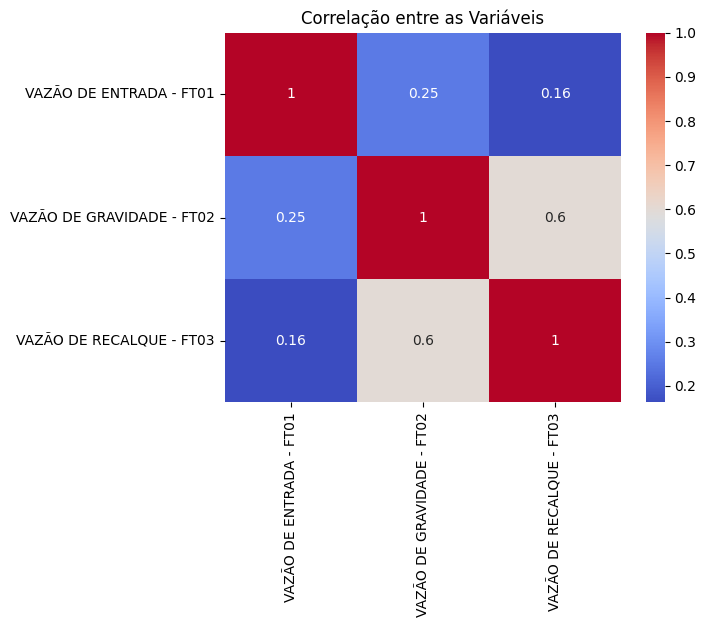

In [25]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Selecionar as variáveis relevantes
variaveis = ['VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03']
df_variaveis = df_horarios_pico[variaveis]

# Calcular a matriz de correlação
correlacoes = df_variaveis.corr()

# Plotar um heatmap da matriz de correlação
sns.heatmap(correlacoes, annot=True, cmap='coolwarm')
plt.title('Correlação entre as Variáveis')
plt.show()


In [26]:
demanda_media = df['VAZÃO DE RECALQUE - FT03'].mean()
demanda_media_formatada = format(round(demanda_media, 2), ".2f")

print(f"A demanda média é: {demanda_media_formatada}")


A demanda média é: 100.14


In [27]:
demanda_media = df['VAZÃO DE ENTRADA - FT01'].mean()
demanda_media_formatada = format(round(demanda_media, 2), ".2f")

print(f"A demanda média é: {demanda_media_formatada}")



A demanda média é: 211.77


In [28]:
demanda_media = df['VAZÃO DE GRAVIDADE - FT02'].mean()
demanda_media_formatada = format(round(demanda_media, 2), ".2f")

print(f"A demanda média é: {demanda_media_formatada}")



A demanda média é: 113.80


In [29]:
filtro = (df.index.year>=2018)
df = df[filtro]
filtro = (df.index.year<=2020)
df = df[filtro]
# filtro = (df.index.hour>=18)
# df = df[filtro]
# filtro = (df.index.hour<=21)
# df = df[filtro]

hora = '24h'

df.isna().any() # verifique se não há valores NAN
df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1',
                        'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2',
                        'BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3',
                        'BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01',
                        'BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA - FT01',
                        'BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02',
                        'BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03',
                        'BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01',
                        'BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})
df

FREQUENCIA BOMBA 1  FREQUENCIA BOMBA 2  \
Timestamp                                                     
2018-01-01 00:00:00           39.716118            0.000000   
2018-01-01 01:00:00           40.692509            0.000000   
2018-01-01 02:00:00           34.512108            0.000000   
2018-01-01 03:00:00           33.531471            0.000000   
2018-01-01 04:00:00           33.191261            0.000000   
...                                 ...                 ...   
2020-12-31 19:00:00           57.988792           46.797836   
2020-12-31 20:00:00           57.988792           47.061192   
2020-12-31 21:00:00            0.000000           45.869583   
2020-12-31 22:00:00            0.000000           46.035812   
2020-12-31 23:00:00            0.000000            0.000000   

                     FREQUENCIA BOMBA 3  NIVEL DO RESERVATÓRIO - LT01  \
Timestamp                                                               
2018-01-01 00:00:00            0.000000                      4.027903   
2018-01-01 01:00:00            0.000000                      4.241524   
2018-01-01 02:00:00            0.000000                      4.352295   
2018-01-01 03:00:00            0.000000                      4.136808   
2018-01-01 04:00:00            0.000000                      3.947308   
...                                 ...                           ...   
2020-12-31 19:00:00            0.000000                      3.669613   
2020-12-31 20:00:00            0.000000                      3.221217   
2020-12-31 21:00:00           57.988792                      2.803498   
2020-12-31 22:00:00           57.988792                      2.492699   
2020-12-31 23:00:00           54.145569                      2.622920   

                     VAZÃO DE ENTRADA - FT01  VAZÃO DE GRAVIDADE - FT02  \
Timestamp                                                                 
2018-01-01 00:00:00               270.285187                  76.920532   
2018-01-01 01:00:00               268.635803                  83.023201   
2018-01-01 02:00:00                 0.000000                  82.351860   
2018-01-01 03:00:00                 0.000000                  69.360985   
2018-01-01 04:00:00                 0.000000                  59.742775   
...                                      ...                        ...   
2020-12-31 19:00:00                 0.115741                 149.436783   
2020-12-31 20:00:00                 0.115741                 151.018051   
2020-12-31 21:00:00                 0.115741                 129.294189   
2020-12-31 22:00:00               282.855591                 111.951515   
2020-12-31 23:00:00               277.031158                 106.797119   

                     VAZÃO DE RECALQUE - FT03  PRESSÃO DE SUCÇÃO - PT01  \
Timestamp                                                                 
2018-01-01 00:00:00                 61.992577                  5.232423   
2018-01-01 01:00:00                 66.538521                  5.431031   
2018-01-01 02:00:00                 57.269573                  5.555567   
2018-01-01 03:00:00                 52.244926                  5.358496   
2018-01-01 04:00:00                 49.718590                  5.184939   
...                                       ...                       ...   
2020-12-31 19:00:00                121.814819                  4.499011   
2020-12-31 20:00:00                117.933388                  4.070826   
2020-12-31 21:00:00                106.692932                  3.714235   
2020-12-31 22:00:00                 98.773148                  3.443493   
2020-12-31 23:00:00                 87.587082                  3.610525   

                     PRESSÃO DE RECALQUE - PT02  
Timestamp                                        
2018-01-01 00:00:00                   13.961227  
2018-01-01 01:00:00                   13.961227  
2018-01-01 02:00:00                   11.049756  
2018-01-01 03:00:00                   11.115347  

In [30]:
df.replace(to_replace='Bad',value=np.nan,inplace=True)
df.isna().any() # verifique se existem valores NAN (sequências 'Bad' substituídas)
df.interpolate(inplace=True)

df = df.dropna()

# 24 horas

df = df.resample('24h').mean()
# df = df.resample('24h').min()
# df2 = df.resample('24h', offset = "19h").mean()
# df3 = df.resample('24h', offset = "20h").mean()
# df4 = df.resample('24h', offset = "21h").mean()
df.shape

(1096, 9)

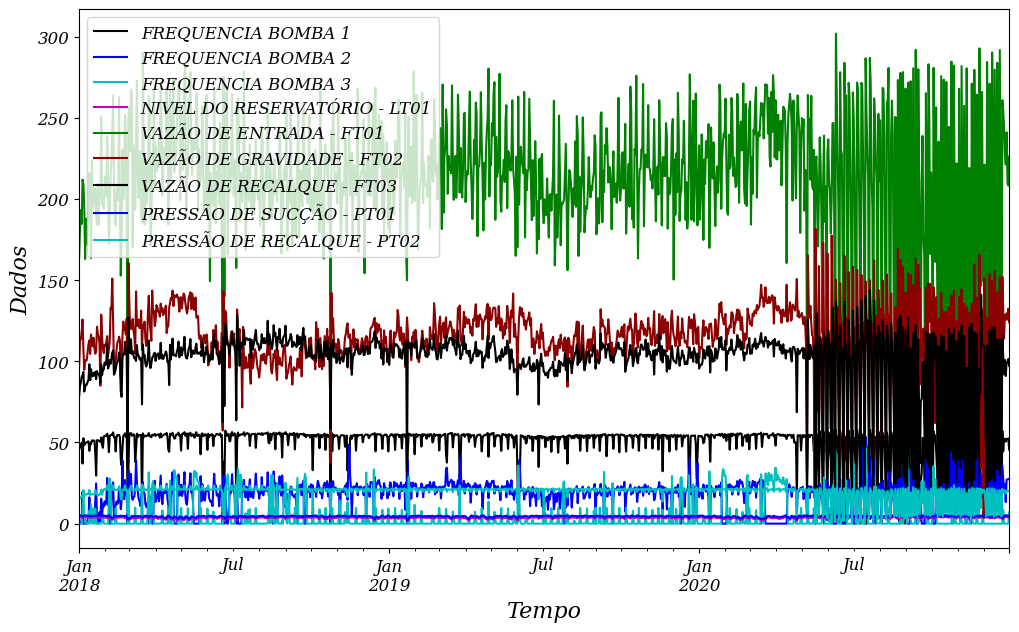

In [31]:

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
# gráfico de linha
df.plot(figsize = (12,7), color = ['k', 'b', 'c', 'm', 'g', 'darkred'])
plt.xlabel('Tempo', fontsize = 16)
plt.ylabel("Dados", fontsize = 16)
plt.legend(loc = 2)
plt.savefig("dados todo.pdf", dpi=500)
plt.show()


In [32]:
# from fast_ml.model_development import train_valid_test_split

# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = target, 
#                                                                             train_size=0.8, valid_size=0.1, test_size=0.1)

# # Get the shape of all the datasets
# print(X_train.shape), print(y_train.shape)
# print(X_valid.shape), print(y_valid.shape)
# print(X_test.shape), print(y_test.shape)

# Treino, test e validação


In [33]:
#%% Divide os dados em treinamento, validação e teste
# 70% para treinamento e validação (18.414 amostras) e 30% para teste (7.892 amostras)
# Das 18.414 amostras, 80% para treinamento (14.731 amostras) e 20% para validação (3.683 amostras)

# thresholds
trn_samples = int((len(df)*70/100)*(80/100))
vld_samples = int((len(df)*70/100)*(20/100))
tst_samples = int((len(df)*30/100))

trn = df.iloc[:trn_samples]
vld = df.iloc[trn_samples:trn_samples+vld_samples]
tst = df.iloc[trn_samples+vld_samples:]

endog_tst = tst['NIVEL DO RESERVATÓRIO - LT01']
exog_tst = tst[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]



endog_vld = vld['NIVEL DO RESERVATÓRIO - LT01']
exog_vld = vld[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA - FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]


       
endog_trn = trn['NIVEL DO RESERVATÓRIO - LT01']
exog_trn = trn[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA - FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]



endog = df['NIVEL DO RESERVATÓRIO - LT01']
exog = df[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog = df[['PRESSÃO DE SUCÇÃO - PT01']]


rt = 'LT01 (m³)'

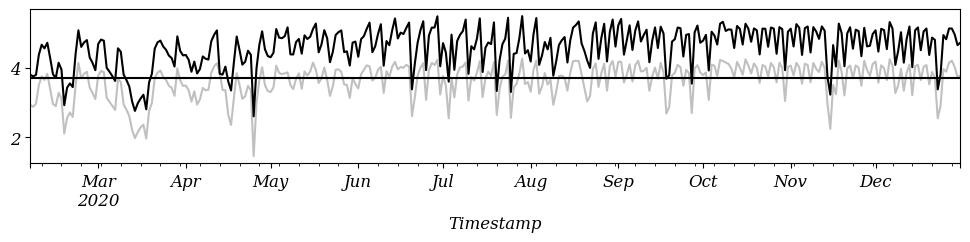

In [34]:
plt.figure(figsize = (12,2))
tst['NIVEL DO RESERVATÓRIO - LT01'].plot(color = 'silver')
tst['PRESSÃO DE SUCÇÃO - PT01'].plot(color = 'black')
plt.axhline(y=3.7, color = 'black')
plt.show()

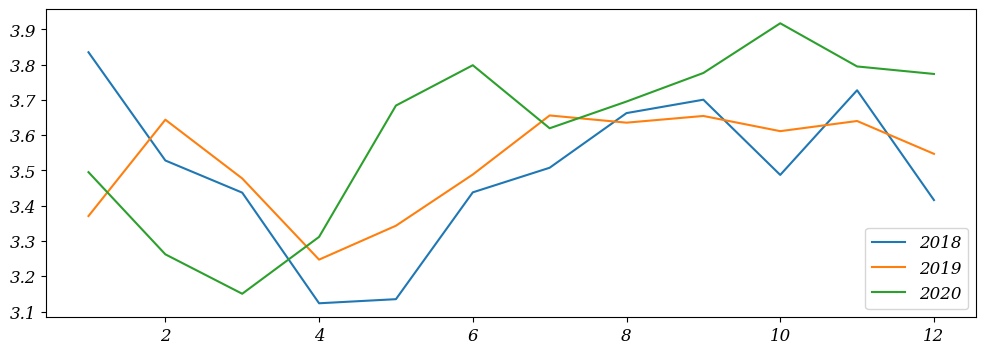

In [35]:

## Agrupando por ano
idx_year = df.index.year
idx_month = df.index.month
plt.figure(figsize = (12,4))
plt.plot(endog.groupby(by = [idx_year, idx_month]).mean().unstack(level = 0))
# plt.title('Agruapdo por Ano')
plt.legend(['2018','2019', '2020'])
# plt.legend(['2020'])
plt.savefig(f"media-agrupada.pdf", dpi=500)
plt.show()

## Diferença com o valor anterior

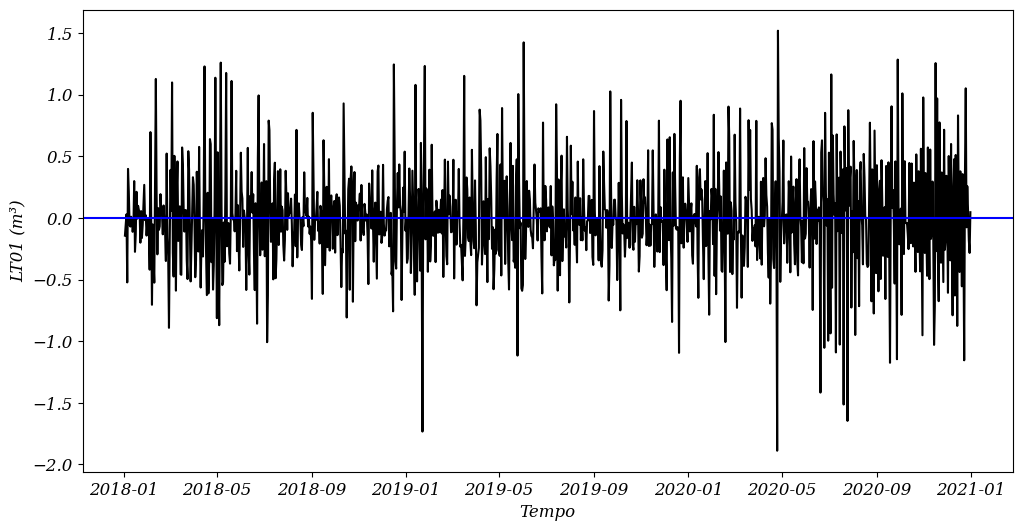

In [36]:

plt.figure(figsize = (12,6))

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog.diff(), 'black')
plt.axhline(y=0, color = 'b')
plt.ylabel(rt)
plt.xlabel("Tempo")
plt.savefig("estacionaridade.pdf", dpi=500)
plt.show()

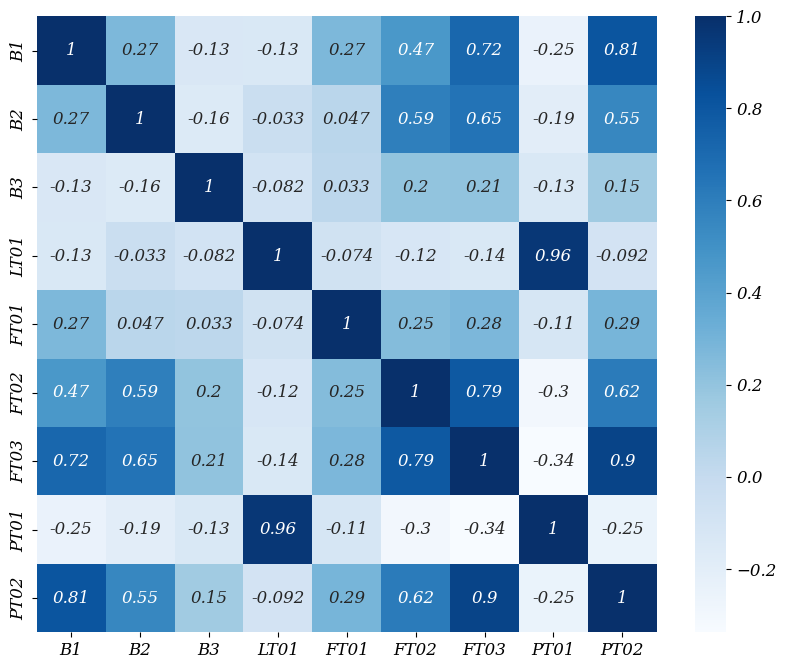

In [159]:
df2 = df.rename(columns={'FREQUENCIA BOMBA 1': 'B1',
                        'FREQUENCIA BOMBA 2': 'B2',
                        'FREQUENCIA BOMBA 3': 'B3',
                        'NIVEL DO RESERVATÓRIO - LT01': 'LT01',
                        'VAZÃO DE ENTRADA - FT01': 'FT01',
                        'VAZÃO DE GRAVIDADE - FT02': 'FT02',
                        'VAZÃO DE RECALQUE - FT03': 'FT03',
                        'PRESSÃO DE SUCÇÃO - PT01': 'PT01',
                        'PRESSÃO DE RECALQUE - PT02': 'PT02'})

plt.figure(figsize = (10,8))
sns.color_palette(as_cmap = True)
sns.heatmap(df2.corr(method = 'pearson'), annot = True, cmap = 'Blues')
plt.savefig(f"person.pdf", dpi=500)
plt.show()

In [38]:
# from pandas_profiling import ProfileReport
# import sweetviz as sv

# # EDA using pandas-profiling
# profile = ProfileReport(df, explorative=True)

# #Saving results to a HTML file
# profile.to_file("output.html")

# # EDA using Autoviz
# sweet_report = sv.analyze(df)

# #Saving results to HTML file
# sweet_report.show_html('sweet_report.html')


In [39]:
# plt.plot(df2.LT01)

In [40]:

# import dtale


# dtale.show(df2)

In [41]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# s = df2['LT01']
# sd_result = seasonal_decompose(s, model='additive')

In [42]:
from statsmodels.tsa.filters.hp_filter import hpfilter

s = df['NIVEL DO RESERVATÓRIO - LT01']
cycle, trend = hpfilter(s, lamb=1600)

In [43]:
# sd_result.plot();

# Ruido branco

In [44]:
df.mean()

FREQUENCIA BOMBA 1               48.830497
FREQUENCIA BOMBA 2               17.538055
FREQUENCIA BOMBA 3                4.298657
NIVEL DO RESERVATÓRIO - LT01      3.544512
VAZÃO DE ENTRADA - FT01         211.770616
VAZÃO DE GRAVIDADE - FT02       113.804986
VAZÃO DE RECALQUE - FT03        100.138612
PRESSÃO DE SUCÇÃO - PT01          4.485225
PRESSÃO DE RECALQUE - PT02       19.424306
dtype: float64

In [45]:
df2.mean().to_excel('media.xlsx')


In [160]:
df2.describe().to_excel('estatistica.xlsx')

In [161]:
df.describe()

FREQUENCIA BOMBA 1  FREQUENCIA BOMBA 2  FREQUENCIA BOMBA 3  \
count           26306.000           26306.000           26306.000   
mean               48.831              17.539               4.298   
std                17.040              19.981              14.122   
min                 0.000               0.000               0.000   
25%                47.118               0.000               0.000   
50%                57.762               0.000               0.000   
75%                57.989              36.874               0.000   
max                59.988              59.992              59.988   

       NIVEL DO RESERVATÓRIO - LT01  VAZÃO DE ENTRADA - FT01  \
count                     26306.000                26306.000   
mean                          3.545                  211.772   
std                           0.668                  114.038   
min                           0.259                    0.000   
25%                           3.121                  254.292   
50%                           3.740                  265.572   
75%                           4.071                  273.737   
max                           4.457                  390.683   

       VAZÃO DE GRAVIDADE - FT02  VAZÃO DE RECALQUE - FT03  \
count                  26306.000                 26306.000   
mean                     113.805                   100.139   
std                       52.960                    35.519   
min                        0.000                     0.000   
25%                       72.327                    77.636   
50%                      122.310                   109.031   
75%                      150.385                   124.623   
max                      442.858                   199.595   

       PRESSÃO DE SUCÇÃO - PT01  PRESSÃO DE RECALQUE - PT02  
count                 26306.000                   26306.000  
mean                      4.485                      19.425  
std                       0.721                       6.007  
min                       0.629                       0.000  
25%                       4.032                      17.969  
50%                       4.623                      20.992  
75%                       5.031                      23.035  
max                       5.723                      29.008


# Métodos preditivos

In [48]:

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df2.LT01.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -4.248240
p-value: 0.000545


<Figure size 1200x200 with 0 Axes>

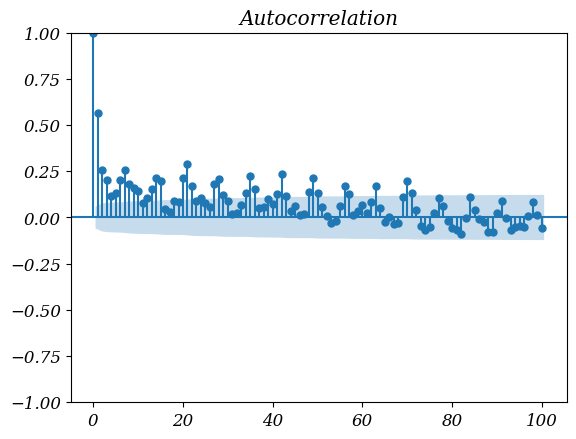

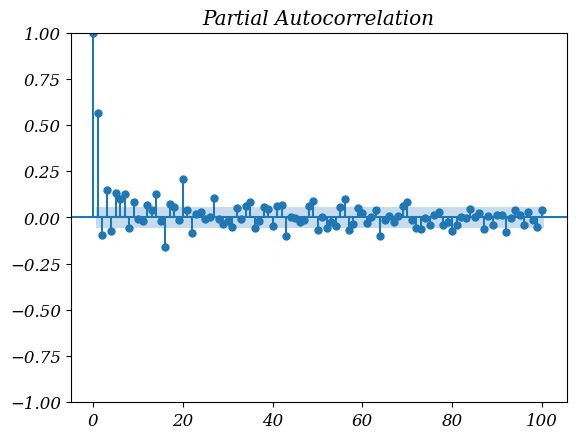

In [49]:

plt.figure(figsize = (12,2))
plot_acf(endog,lags=100)
plot_pacf(endog,lags=100)
plt.show()


## Estacionalidade


In [50]:

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Passa numa série cronológica e num título opcional, devolve um relatório ADF
    """
    print(f'Teste de Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['Estatística de teste ADF', 'p-valor', '# atrasos utilizados', '# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'valor crítico ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Fortes provas contra a hipótese nula")
        print("Rejeitar a hipótese nula")
        print("Os dados não têm raiz unitária e são estacionários")
    else:
        print("Fracas provas contra a hipótese nula")
        print("Não rejeitar a hipótese nula")
        print("Os dados têm uma raiz unitária e não são estacionários")


adf_test(endog)


Teste de Dickey-Fuller Aumentado: 
Estatística de teste ADF      -4.248240
p-valor                        0.000545
# atrasos utilizados          21.000000
# observações               1074.000000
valor crítico (1%)            -3.436453
valor crítico (5%)            -2.864235
valor crítico (10%)           -2.568205
Fortes provas contra a hipótese nula
Rejeitar a hipótese nula
Os dados não têm raiz unitária e são estacionários


# Decomposição STL

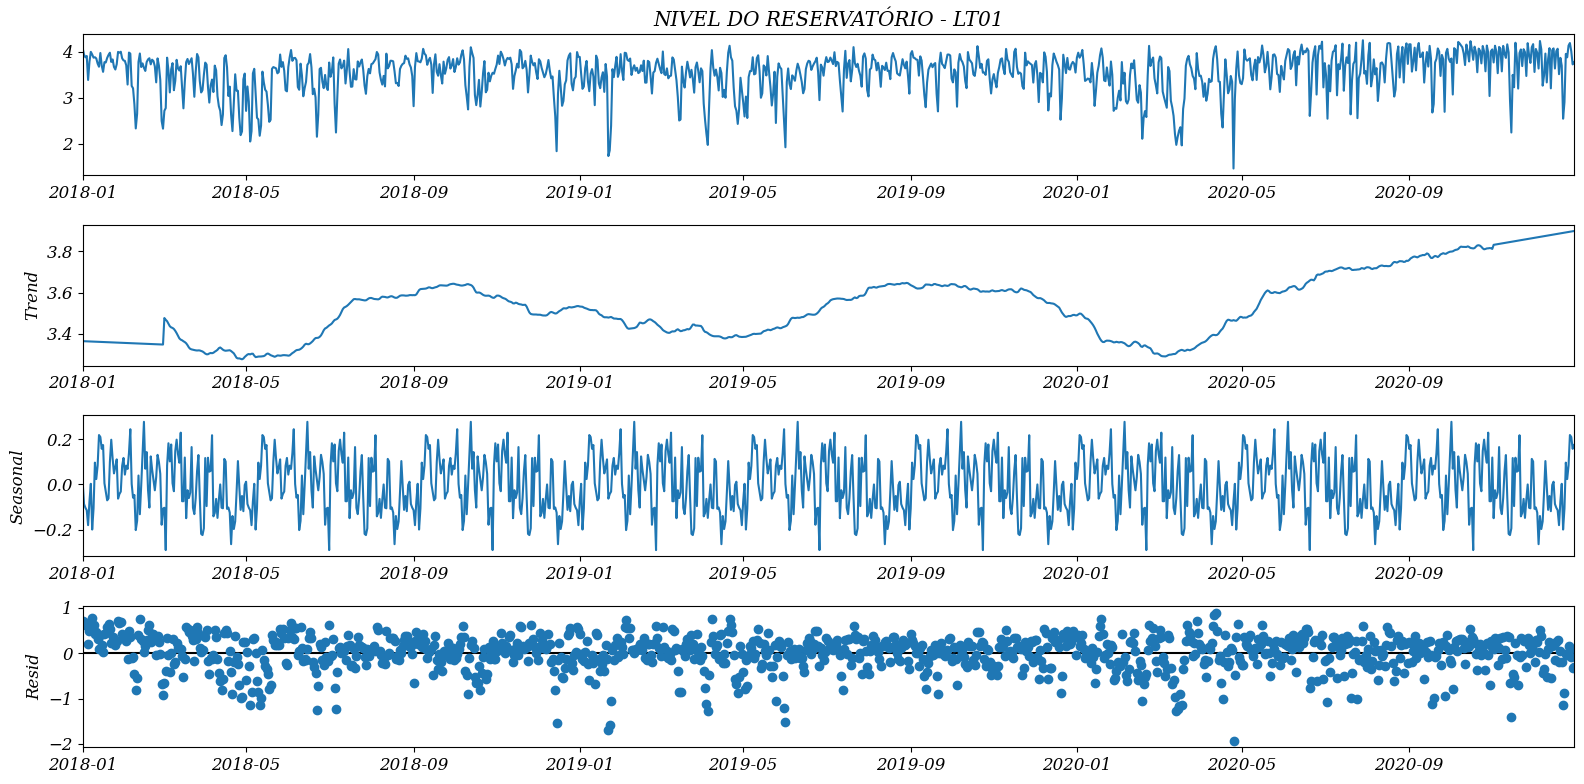

In [51]:

rst = stl(endog, model='add', extrapolate_trend='freq', period=10*12)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.plot()
plt.show()


<Figure size 1500x600 with 0 Axes>

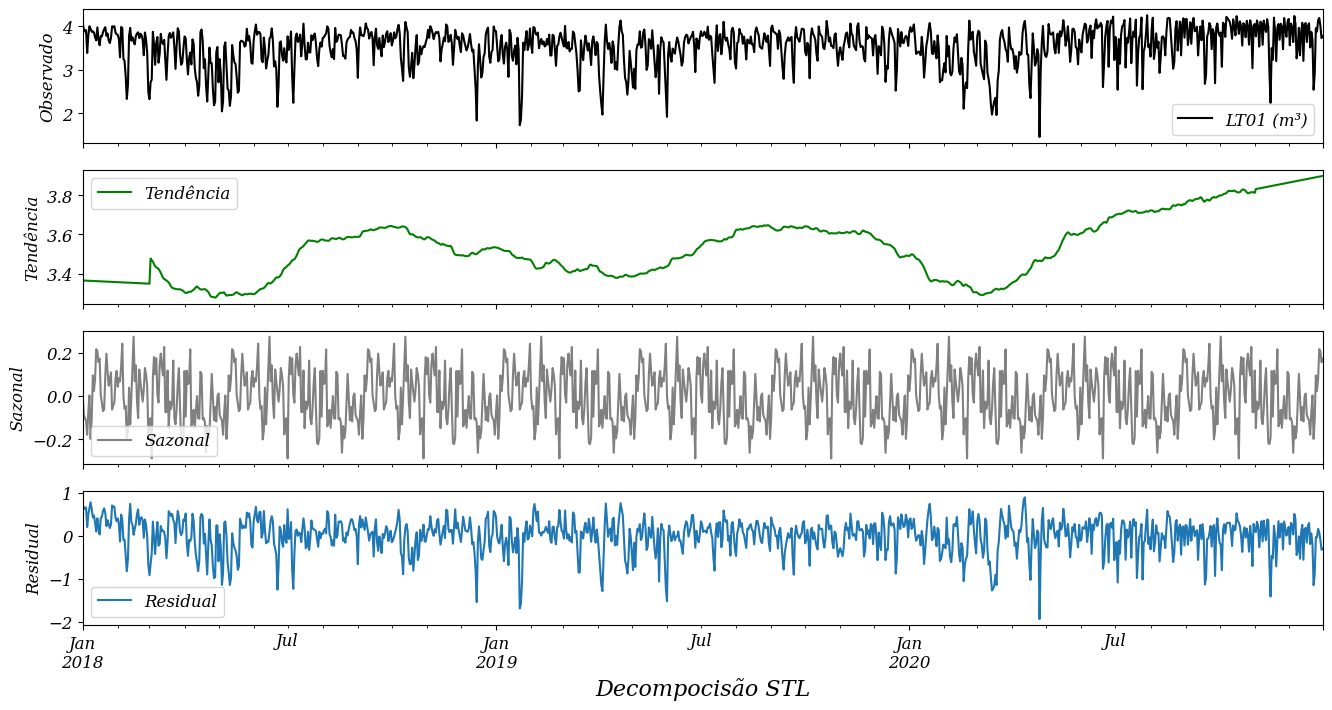

In [52]:
plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
fig, axes = plt.subplots(4, 1, sharex=True)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.observed.plot(ax=axes[0], legend=True, label = rt, color='black')
axes[0].set_ylabel('Observado')
rst.trend.plot(ax=axes[1], legend=True, label = 'Tendência', color='g')
axes[1].set_ylabel('Tendência')
rst.seasonal.plot(ax=axes[2], legend=True, label = 'Sazonal', color = 'gray')
axes[2].set_ylabel('Sazonal')
rst.resid.plot(ax=axes[3], legend=True, label = 'Residual')
axes[3].set_ylabel('Residual')
plt.xlabel( 'Decompocisão STL', fontsize = 16)
plt.savefig("STL.pdf", dpi=500)
plt.show()


In [53]:


from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(endog)


(0.01, False)

In [54]:
# ## Auto ARIMA 
# from pmdarima import auto_arima
# stepwise_fit = auto_arima(endog_trn, start_p=0, start_q=0,
#                           max_p=10, max_q=10, m=12,
#                           start_P=0, seasonal=True,
#                           d=0, D=1, trace=True,
#                           error_action='ignore',   # não queremos saber se uma encomenda não funciona
#                           suppress_warnings=True,  # não queremos avisos de convergência
#                           stepwise=True)           # programado para escalonar
# stepwise_fit.summary()


## Modelo atualizado

In [55]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]+arima[22]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [56]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [57]:
# best = pd.read_excel("best.xlsx")
# p1 = int(best['p'])
# d1 = int(best['d'])
# q1 = int(best['q'])
# P1 = int(best['P'])
# D1 = int(best['D'])
# Q1 = int(best['Q'])
# M1 = int(best['M'])

In [58]:
p1 = 7
d1 = 1
q1 = 7
P1 = 2
D1 = 1
Q1 = 0
M1 = 12

# Modelos de previsão


## Numeros de dias


In [59]:
# # Sem as 24 horas
# pv = 7*24
# pvl = str(int(pv/24))+' dias a frente'

# print(pv, pvl)
# 1, 7, 14, 30
# Com as 24 horas
pv = 30
pvl = str(pv)+' dias à frente'

print(pv, pvl)

30 30 dias à frente


## Auto-Regressivo Exogedo (ARX)

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARX (7) MAPE Error: 0.135 Train
ARX (7) MAPE Error: 0.086 Validation
ARX (7) MAPE Error: 0.141 Test
ARX (7) MAPE Error: 0.137 
ARX (7) MAE Error: 0.432 Train
ARX (7) MAE Error: 0.302 Validation
ARX (7) MAE Error: 0.462 Test
ARX (7) MAE Error: 0.447 
ARX (7) RMSE Error: 0.592 Train
ARX (7) RMSE Error: 0.434 Validation
ARX (7) RMSE Error: 0.628 Test
ARX (7) RMSE Error: 0.360 


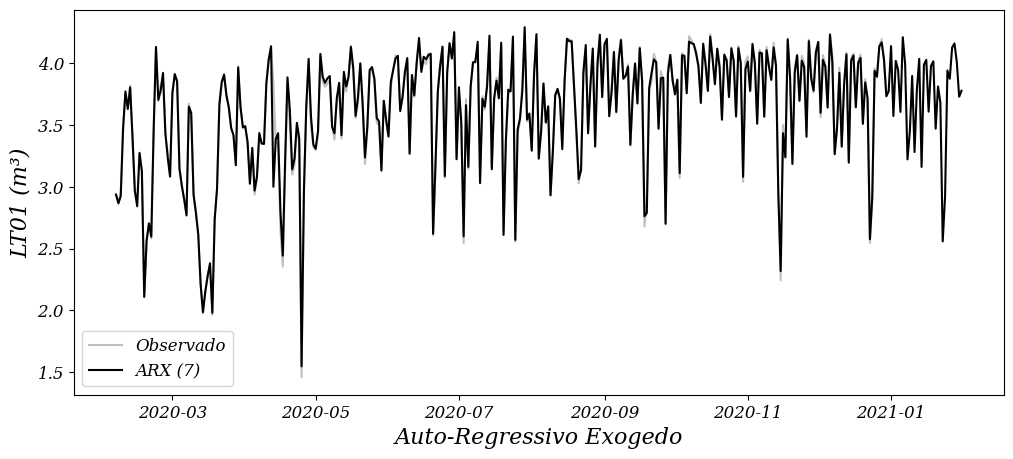

In [60]:
model_trn = ARIMA(endog_trn, exog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, exog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, exog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, exog, order = (p1,0,0))
res = model.fit()

### Previsão

arx_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arx_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arx_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arx = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])

### Erros AR

mape_ARX_trn = mean_absolute_percentage_error(endog_trn, arx_trn[pv+1:])
mape_ARX_vld = mean_absolute_percentage_error(endog_vld, arx_vld[pv+1:])
mape_ARX_tst = mean_absolute_percentage_error(endog_tst, arx_tst[pv+1:])
ARX_mape = mean_absolute_percentage_error(endog, arx[pv+1:])

mae_ARX_trn = mean_absolute_error(endog_trn, arx_trn[pv+1:])
mae_ARX_vld = mean_absolute_error(endog_vld, arx_vld[pv+1:])
mae_ARX_tst = mean_absolute_error(endog_tst, arx_tst[pv+1:])
ARX_mae = mean_absolute_error(endog, arx[pv+1:])

rmse_ARX_trn = mean_squared_error(endog_trn, arx_trn[pv+1:], squared = False)
rmse_ARX_vld = mean_squared_error(endog_vld, arx_vld[pv+1:], squared = False)
rmse_ARX_tst = mean_squared_error(endog_tst, arx_tst[pv+1:], squared = False)
ARX_rmse = mean_squared_error(endog, arx[pv+1:])


print(f"ARX ({p1}) MAPE Error: {mape_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAPE Error: {mape_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAPE Error: {mape_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAPE Error: {ARX_mape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_mae:2.3f} ")

print(f"ARX ({p1}) RMSE Error: {rmse_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) RMSE Error: {rmse_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) RMSE Error: {rmse_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) RMSE Error: {ARX_rmse:2.3f} ")

### Plotagem das previsão



# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arx_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
plt.legend(['Observado', f"ARX ({p1})"])
plt.savefig(f'{pv}-ARX.pdf', dpi=500)
plt.show()


# Lag Ljung Box

In [61]:
lag = [10]
lag

[10]

In [62]:

lj_arx_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arx_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arx_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arx_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## Auto-Regressivo (AR)


AR (7) MAPE Error: 0.121 Train
AR (7) MAPE Error: 0.091 Validation
AR (7) MAPE Error: 0.117 Test
AR (7) MAPE Error: 0.114 
AR (7) MAE Error: 0.383 Train
AR (7) MAE Error: 0.311 Validation
AR (7) MAE Error: 0.375 Test
AR (7) MAE Error: 0.367 
AR (7) RMSE Error: 0.514 Train
AR (7) RMSE Error: 0.390 Validation
AR (7) RMSE Error: 0.495 Test
AR (7) RMSE Error: 0.237 


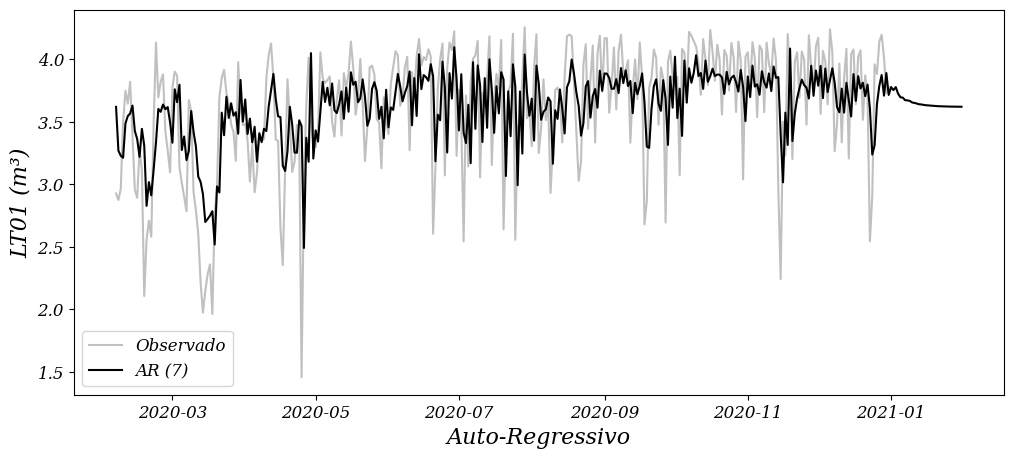

In [63]:
model_trn = ARIMA(endog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, order = (p1,0,0))
res = model.fit()

### Previsão

ar_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ar_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ar_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
ar = res.predict(start = -len(df), end = len(df)+pv)

### Erros AR

mape_AR_trn = mean_absolute_percentage_error(endog_trn, ar_trn[pv+1:])
mape_AR_vld = mean_absolute_percentage_error(endog_vld, ar_vld[pv+1:])
mape_AR_tst = mean_absolute_percentage_error(endog_tst, ar_tst[pv+1:])
AR_mape = mean_absolute_percentage_error(endog, ar[pv+1:])

mae_AR_trn = mean_absolute_error(endog_trn, ar_trn[pv+1:])
mae_AR_vld = mean_absolute_error(endog_vld, ar_vld[pv+1:])
mae_AR_tst = mean_absolute_error(endog_tst, ar_tst[pv+1:])
AR_mae = mean_absolute_error(endog, ar[pv+1:])

rmse_AR_trn = mean_squared_error(endog_trn, ar_trn[pv+1:], squared = False)
rmse_AR_vld = mean_squared_error(endog_vld, ar_vld[pv+1:], squared = False)
rmse_AR_tst = mean_squared_error(endog_tst, ar_tst[pv+1:], squared = False)
AR_rmse = mean_squared_error(endog, ar[pv+1:])

print(f"AR ({p1}) MAPE Error: {mape_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAPE Error: {mape_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAPE Error: {mape_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAPE Error: {AR_mape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_mae:2.3f} ")

print(f"AR ({p1}) RMSE Error: {rmse_AR_trn:2.3f} Train")
print(f"AR ({p1}) RMSE Error: {rmse_AR_vld:2.3f} Validation")
print(f"AR ({p1}) RMSE Error: {rmse_AR_tst:2.3f} Test")
print(f"AR ({p1}) RMSE Error: {AR_rmse:2.3f} ")

### Plotagem das previsão



# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo', fontsize = 16)
plt.legend(['Observado', f"AR ({p1})"])
plt.savefig(f'{pv}-AR.pdf', dpi=500)
plt.show()


# Anomalias AR

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [ 79 135 170]


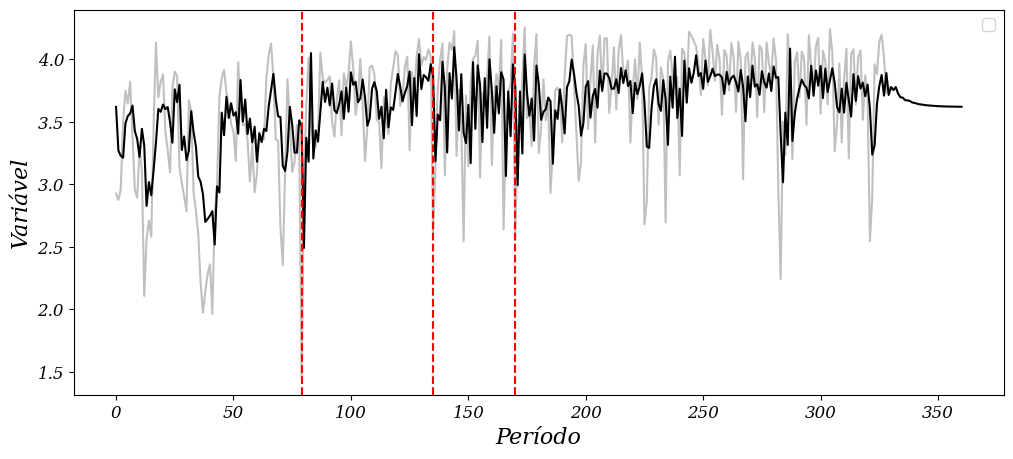

In [64]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(ar_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


In [65]:
lj_ar_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ar_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ar_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ar_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Médias Móveis (MA)


MA (7) MAPE Error: 0.120 Train
MA (7) MAPE Error: 0.090 Validation
MA (7) MAPE Error: 0.120 Test
MA (7) MAPE Error: 0.113 
MA (7) MAE Error: 0.379 Train
MA (7) MAE Error: 0.306 Validation
MA (7) MAE Error: 0.384 Test
MA (7) MAE Error: 0.361 
MA (7) RMSE Error: 0.510 Train
MA (7) RMSE Error: 0.383 Validation
MA (7) RMSE Error: 0.504 Test
MA (7) RMSE Error: 0.477 Test


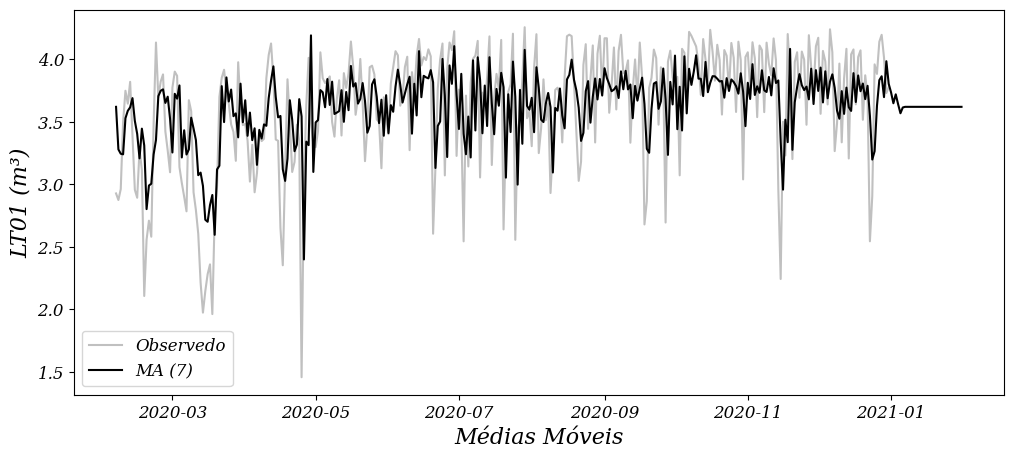

In [66]:

model_trn = ARIMA(endog_trn,order=(0,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(0,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(0,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(0,0,1))
res = model.fit()

### Previsão

ma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
MA = res.predict(start = -len(df), end = len(df)+pv)

### Erros MA

mape_MA_trn = mean_absolute_percentage_error(endog_trn, ma_trn[pv+1:])
mape_MA_vld = mean_absolute_percentage_error(endog_vld, ma_vld[pv+1:])
mape_MA_tst = mean_absolute_percentage_error(endog_tst, ma_tst[pv+1:])
MA_mape = mean_absolute_percentage_error(endog, MA[pv+1:])

mae_MA_trn = mean_absolute_error(endog_trn, ma_trn[pv+1:])
mae_MA_vld = mean_absolute_error(endog_vld, ma_vld[pv+1:])
mae_MA_tst = mean_absolute_error(endog_tst, ma_tst[pv+1:])
MA_mae = mean_absolute_error(endog, MA[pv+1:])

rmse_MA_trn = mean_squared_error(endog_trn, ma_trn[pv+1:], squared = False)
rmse_MA_vld = mean_squared_error(endog_vld, ma_vld[pv+1:], squared = False)
rmse_MA_tst = mean_squared_error(endog_tst, ma_tst[pv+1:], squared = False)
MA_rmse = mean_squared_error(endog, MA[pv+1:], squared = False)

print(f"MA ({q1}) MAPE Error: {mape_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAPE Error: {mape_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAPE Error: {mape_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAPE Error: {MA_mape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_mae:2.3f} ")

print(f"MA ({q1}) RMSE Error: {rmse_MA_trn:2.3f} Train")
print(f"MA ({q1}) RMSE Error: {rmse_MA_vld:2.3f} Validation")
print(f"MA ({q1}) RMSE Error: {rmse_MA_tst:2.3f} Test")
print(f"MA ({q1}) RMSE Error: {MA_rmse:2.3f} Test")


### Plotagem das previsão


# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ma_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('Médias Móveis', fontsize = 16)
plt.legend(['Observedo', f"MA ({q1})"])
plt.savefig(f"{pv}-MA.pdf", dpi=500)

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [79]


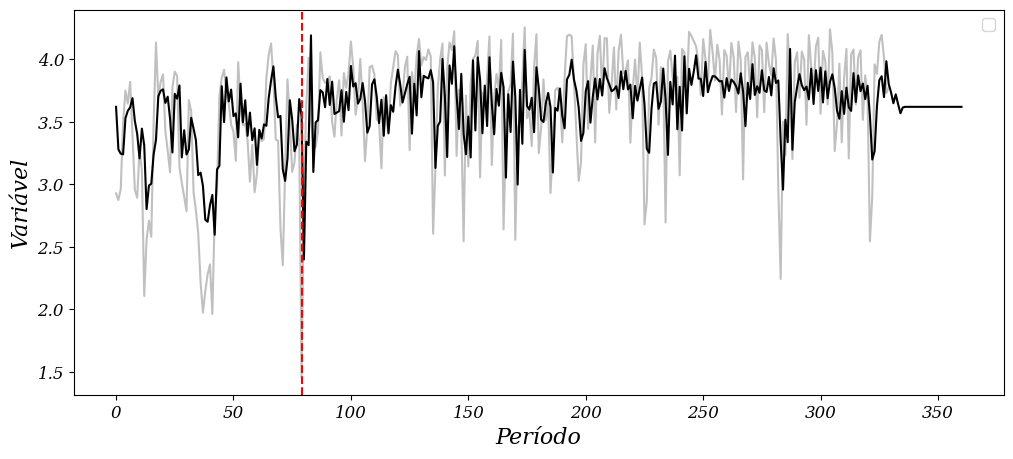

In [67]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(ma_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


In [68]:

lj_ma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## ARMA


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARMA (7, 7) MAPE Error: 0.120 Train
ARMA (7, 7) MAPE Error: 0.089 Validation
ARMA (7, 7) MAPE Error: 0.118 Test
ARMA (7, 7) MAPE Error: 0.120 
ARMA (7, 7) MAE Error: 0.383 Train
ARMA (7, 7) MAE Error: 0.304 Validation
ARMA (7, 7) MAE Error: 0.384 Test
ARMA (7, 7) MAE Error: 0.385
ARMA (7, 7) RMSE Error: 0.508 Train
ARMA (7, 7) RMSE Error: 0.384 Validation
ARMA (7, 7) RMSE Error: 0.496 Test
ARMA (7, 7) RMSE Error: 0.508 Test


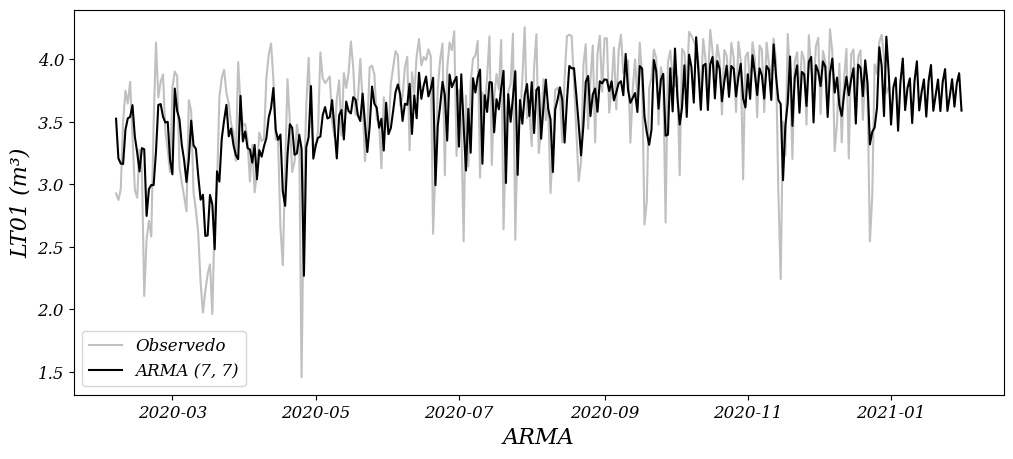

In [69]:

model_trn = ARIMA(endog_trn,order=(p1,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(p1,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(p1,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(p1,0,q1))
res = model.fit()

arma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arma = res.predict(start = -len(df), end = len(df)+pv)


### Erros ARMA



mape_ARMA_trn = mean_absolute_percentage_error(endog_trn, arma_trn[pv+1:])
mape_ARMA_vld = mean_absolute_percentage_error(endog_vld, arma_vld[pv+1:])
mape_ARMA_tst = mean_absolute_percentage_error(endog_tst, arma_tst[pv+1:])
ARMA_mape = mean_absolute_percentage_error(endog, arma[pv+1:])

mae_ARMA_trn = mean_absolute_error(endog_trn, arma_trn[pv+1:])
mae_ARMA_vld = mean_absolute_error(endog_vld, arma_vld[pv+1:])
mae_ARMA_tst = mean_absolute_error(endog_tst, arma_tst[pv+1:])
ARMA_mae = mean_absolute_error(endog, arma[pv+1:])

rmse_ARMA_trn = mean_squared_error(endog_trn, arma_trn[pv+1:], squared = False)
rmse_ARMA_vld = mean_squared_error(endog_vld, arma_vld[pv+1:], squared = False)
rmse_ARMA_tst = mean_squared_error(endog_tst, arma_tst[pv+1:], squared = False)
ARMA_rmse = mean_squared_error(endog, arma[pv+1:], squared = False)


print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAPE Error: {ARMA_mape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_mae:2.3f}")

print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} RMSE Error: {ARMA_rmse:2.3f} Test")

### Plotagem das previsão


# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARMA', fontsize = 16)
plt.legend(['Observedo', f"ARMA {p1,q1}"])
plt.savefig(f"{pv}-ARMA.pdf", dpi=300)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [ 12  79 135 165 170 283]


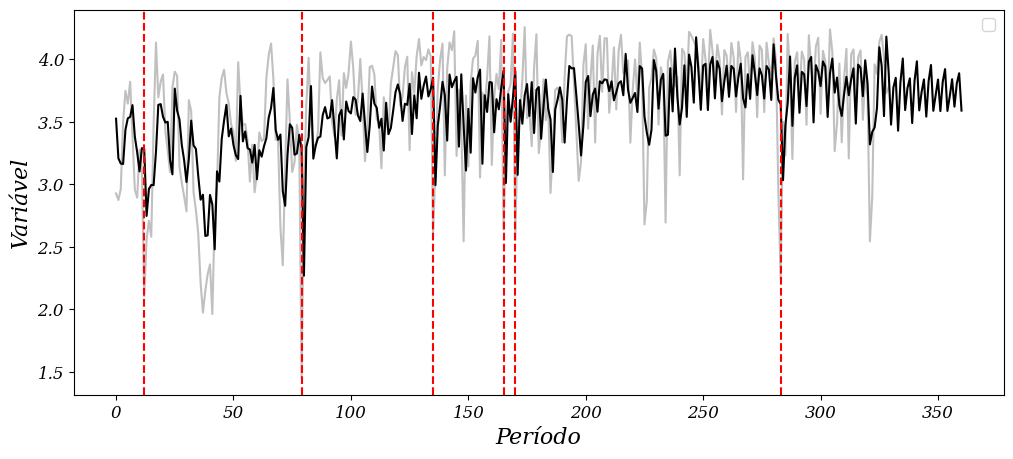

In [70]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arma_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


In [71]:

lj_arma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMA

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA (7, 1, 7) MAPE Error: 0.124 Train
ARIMA (7, 1, 7) MAPE Error: 0.100 Validation
ARIMA (7, 1, 7) MAPE Error: 0.120 Test
ARIMA (7, 1, 7) MAPE Error: 0.117
ARIMA (7, 1, 7) MAE Error: 0.395 Train
ARIMA (7, 1, 7) MAE Error: 0.343 Validation
ARIMA (7, 1, 7) MAE Error: 0.390 Test
ARIMA (7, 1, 7) MAE Error: 0.375
ARIMA (7, 1, 7) RMSE Error: 0.527 Train
ARIMA (7, 1, 7) RMSE Error: 0.426 Validation
ARIMA (7, 1, 7) RMSE Error: 0.509 Test
ARIMA (7, 1, 7) RMSE Error: 0.497


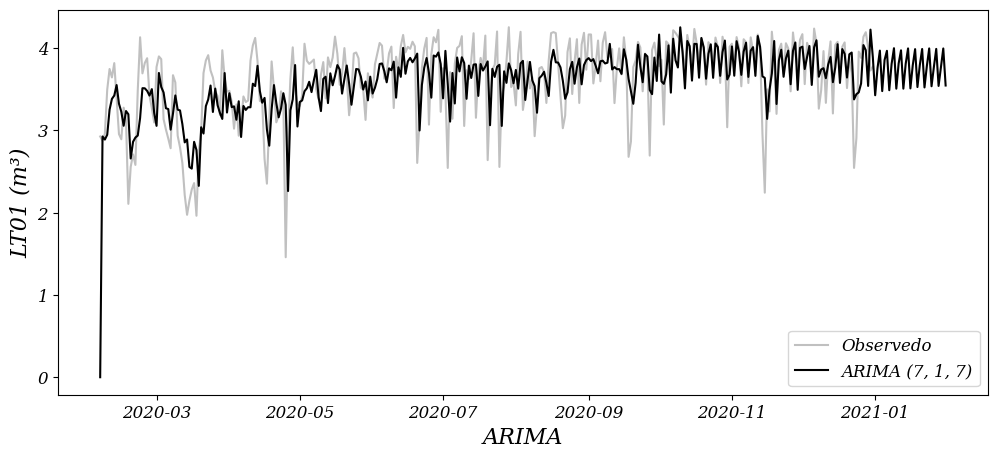

In [72]:

model_trn = ARIMA(endog_trn,
                        order=(p1,d1,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,
                        order=(p1,d1,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,
                        order=(p1,d1,q1))
res_tst = model_tst.fit()

model_df = ARIMA(endog,
                        order=(p1,d1,q1))
res_df = model_df.fit()

arima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arima = res_df.predict(start = -len(df), end = len(df)+pv)

### Erros ARIMA



mape_ARIMA_trn = mean_absolute_percentage_error(endog_trn, arima_trn[pv+1:])
mape_ARIMA_vld = mean_absolute_percentage_error(endog_vld, arima_vld[pv+1:])
mape_ARIMA_tst = mean_absolute_percentage_error(endog_tst, arima_tst[pv+1:])
ARIMA_mape = mean_absolute_percentage_error(endog, arima[pv+1:])

mae_ARIMA_trn = mean_absolute_error(endog_trn, arima_trn[pv+1:])
mae_ARIMA_vld = mean_absolute_error(endog_vld, arima_vld[pv+1:])
mae_ARIMA_tst = mean_absolute_error(endog_tst, arima_tst[pv+1:])
ARIMA_mae = mean_absolute_error(endog, arima[pv+1:])

rmse_ARIMA_trn = mean_squared_error(endog_trn, arima_trn[pv+1:], squared = False)
rmse_ARIMA_vld = mean_squared_error(endog_vld, arima_vld[pv+1:], squared = False)
rmse_ARIMA_tst = mean_squared_error(endog_tst, arima_tst[pv+1:], squared = False)
ARIMA_rmse = mean_squared_error(endog, arima[pv+1:], squared = False)

print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAPE Error: {ARIMA_mape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RMSE Error: {ARIMA_rmse:2.3f}")


# ### Plotagem das previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arima_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARIMA', fontsize = 16)
plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
plt.savefig(f"{pv}-ARIMA.pdf", dpi=500)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [  0  79 135 170 283]


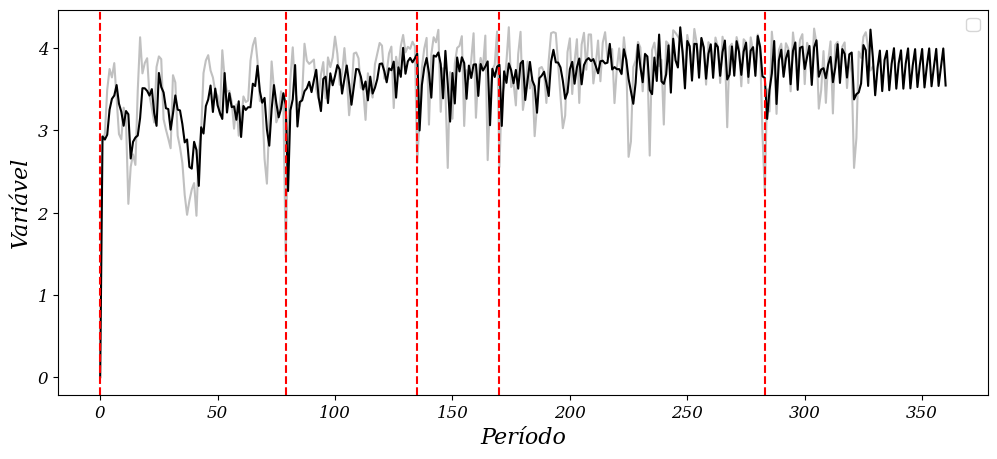

In [73]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arima_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


In [74]:

lj_arima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMA


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 0.126 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 0.098 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 0.132 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 0.124
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.405 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.337 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.431 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.404
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 0.538 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 0.412 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 0.570 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 0.531


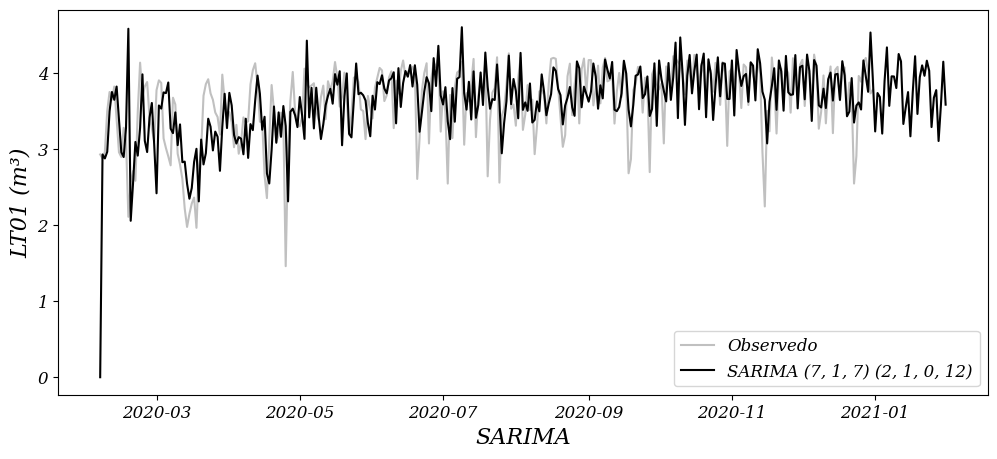

In [75]:
model_trn = sr(endog_trn,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_trn = model_trn.fit(dis=False)

model_vld = sr(endog_vld,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_vld = model_vld.fit(dis=False)

model_tst = sr(endog_tst,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_tst = model_tst.fit(dis=False)

model_df = sr(endog,order=(p1,d1,q1),
                seasonal_order = (P1,D1,Q1,M1),
                simple_differencing=False)
res_df = model_df.fit(dis=False)

### Erro SARIMA

sarima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
sarima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
sarima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
sarima = res_df.predict(start = -len(df), end = len(df)+pv)

mape_SARIMA_trn = mean_absolute_percentage_error(endog_trn, sarima_trn[pv+1:])
mape_SARIMA_vld = mean_absolute_percentage_error(endog_vld, sarima_vld[pv+1:])
mape_SARIMA_tst = mean_absolute_percentage_error(endog_tst, sarima_tst[pv+1:])
SARIMA_mape = mean_absolute_percentage_error(endog, sarima[pv+1:])

mae_SARIMA_trn = mean_absolute_error(endog_trn, sarima_trn[pv+1:])
mae_SARIMA_vld = mean_absolute_error(endog_vld, sarima_vld[pv+1:])
mae_SARIMA_tst = mean_absolute_error(endog_tst, sarima_tst[pv+1:])
SARIMA_mae = mean_absolute_error(endog, sarima[pv+1:])

rmse_SARIMA_trn = mean_squared_error(endog_trn, sarima_trn[pv+1:], squared = False)
rmse_SARIMA_vld = mean_squared_error(endog_vld, sarima_vld[pv+1:], squared = False)
rmse_SARIMA_tst = mean_squared_error(endog_tst, sarima_tst[pv+1:], squared = False)
SARIMA_rmse = mean_squared_error(endog, sarima[pv+1:], squared = False)

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {SARIMA_mape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {SARIMA_rmse:2.3f}")

### Plotagem da previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('SARIMA', fontsize = 16)
plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
plt.savefig(f"{pv}-SARIMA.pdf", dpi=500)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [  0  12  79 283]


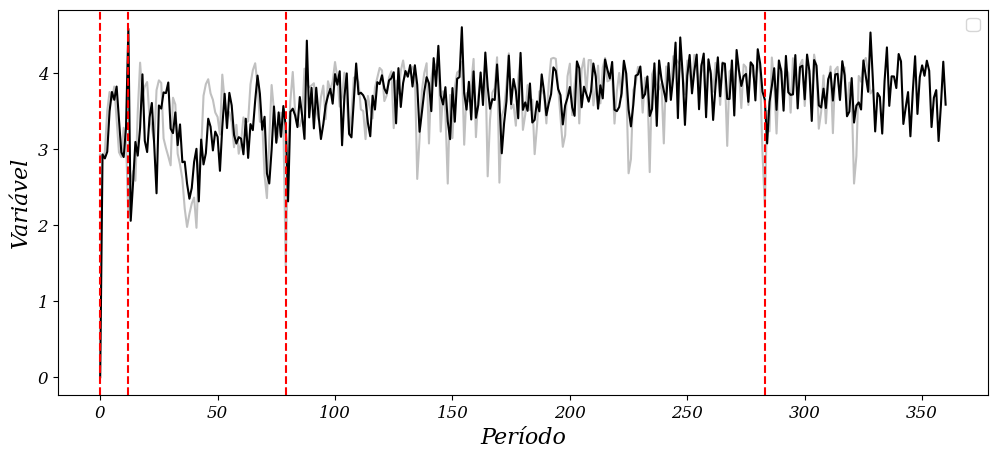

In [76]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(sarima_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


ADF Statistic: -4.2678842574054805
p-value: 0.000504668295643225


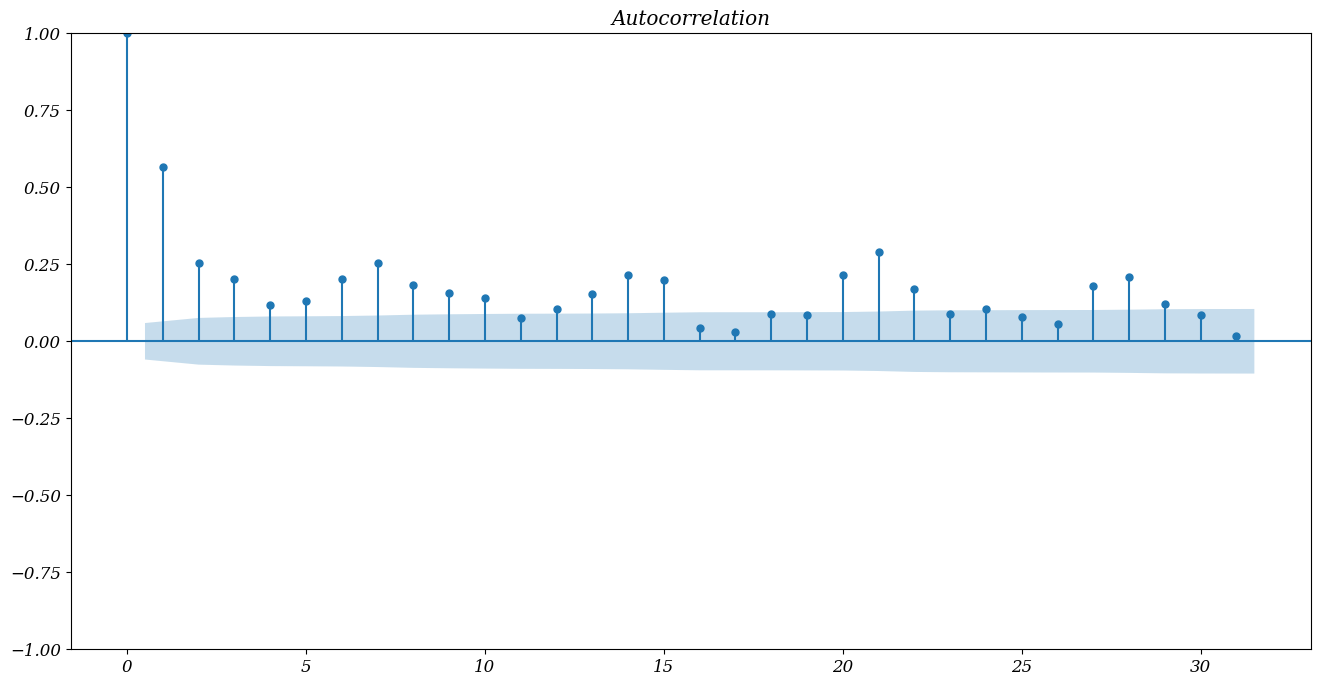

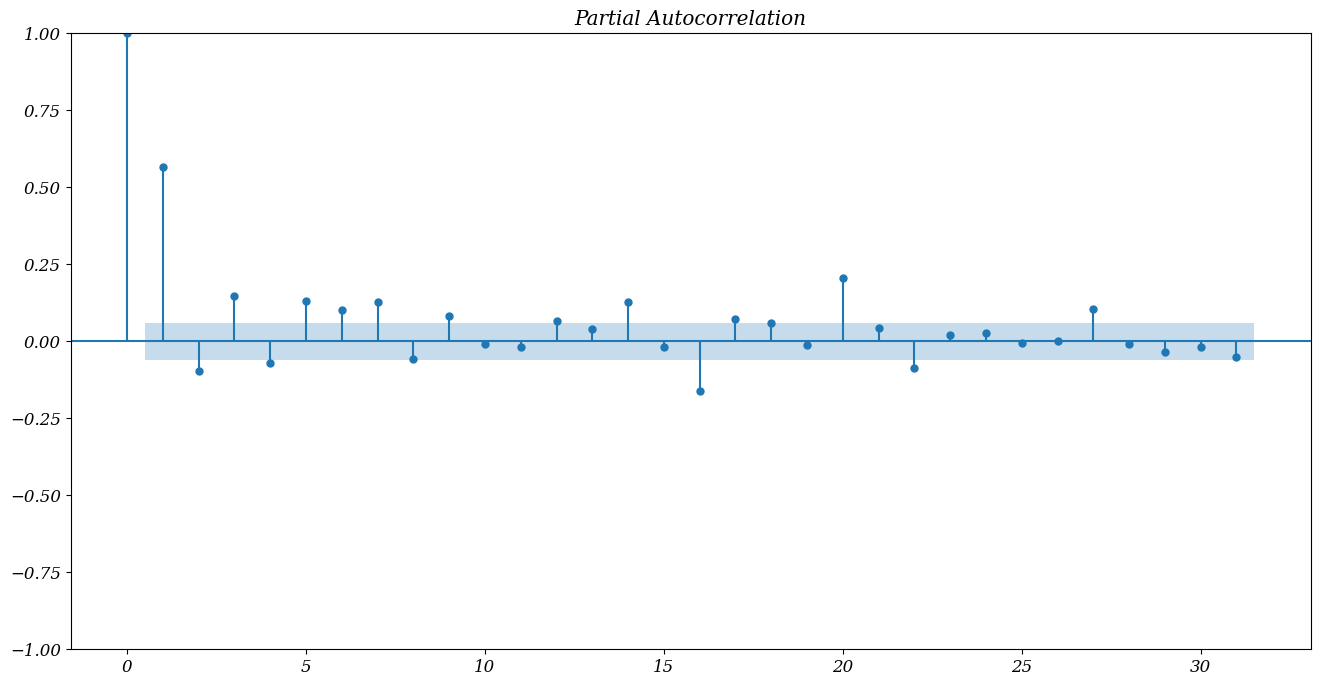

In [77]:

ad_fuller_result = adfuller(endog[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


plot_acf(endog[1:]);
plt.savefig(f"acf.pdf", dpi=500)
plot_pacf(endog[1:]);
plt.savefig(f"pacf.pdf", dpi=500)


In [78]:

lj_sarima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMAX

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX (7, 1, 7)  MAPE Error: 0.136 Train
ARIMAX (7, 1, 7)  MAPE Error: 0.086 Validation
ARIMAX (7, 1, 7)  MAPE Error: 0.140 Test
ARIMAX (7, 1, 7) MAPE Error: 0.136
ARIMAX (7, 1, 7)  MAE Error: 0.434 Train
ARIMAX (7, 1, 7)  MAE Error: 0.301 Validation
ARIMAX (7, 1, 7)  MAE Error: 0.459 Test
ARIMAX (7, 1, 7) MAE Error: 0.443
ARIMAX (7, 1, 7)  RMSE Error: 0.594 Train
ARIMAX (7, 1, 7)  RMSE Error: 0.433 Validation
ARIMAX (7, 1, 7)  RMSE Error: 0.627 Test
ARIMAX (7, 1, 7) RMSE Error: 0.596


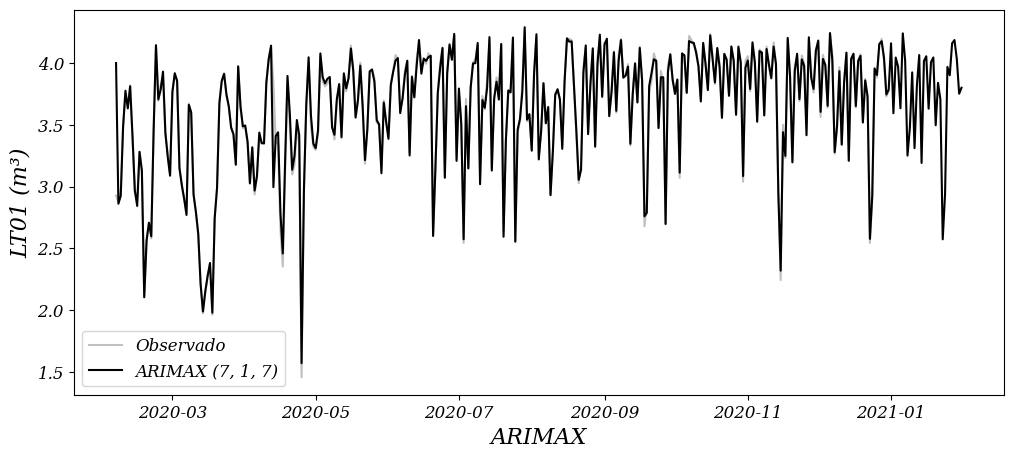

In [79]:

best_model_tst = ARIMA(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1))


res_tst = best_model_tst.fit()
### Validação



best_model_vld = ARIMA(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1))

res_vld = best_model_vld.fit()

### Treino

best_model_trn = ARIMA(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1))

res_trn = best_model_trn.fit()

### ARIMAX

best_model = ARIMA(endog, 
                     exog, 
                     order=(p1,d1,q1))

res = best_model.fit()



### Prevendo ARIMAX

arimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])


### Erros ARIMAX

mape_arimax_trn = mean_absolute_percentage_error(endog_trn, arimax_trn[pv+1:])
mape_arimax_vld = mean_absolute_percentage_error(endog_vld, arimax_vld[pv+1:])
mape_arimax_tst = mean_absolute_percentage_error(endog_tst, arimax_tst[pv+1:])
arimax_mape = mean_absolute_percentage_error(endog, arimax[pv+1:])

mae_arimax_trn = mean_absolute_error(endog_trn, arimax_trn[pv+1:])
mae_arimax_vld = mean_absolute_error(endog_vld, arimax_vld[pv+1:])
mae_arimax_tst = mean_absolute_error(endog_tst, arimax_tst[pv+1:])
arimax_mae = mean_absolute_error(endog, arimax[pv+1:])

rmse_arimax_trn = mean_squared_error(endog_trn, arimax_trn[pv+1:], squared = False)
rmse_arimax_vld = mean_squared_error(endog_vld, arimax_vld[pv+1:], squared = False)
rmse_arimax_tst = mean_squared_error(endog_tst, arimax_tst[pv+1:], squared = False)
arimax_rmse = mean_squared_error(endog, arimax[pv+1:], squared = False)

print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} MAPE Error: {arimax_mape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} MAE Error: {arimax_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} RMSE Error: {arimax_rmse:2.3f}")

# # Visualiza previsão
# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arimax_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel(f'ARIMAX', fontsize = 16)
plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
plt.savefig(f"{pv}-ARIMAX.pdf", dpi=500)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [ 0 67]


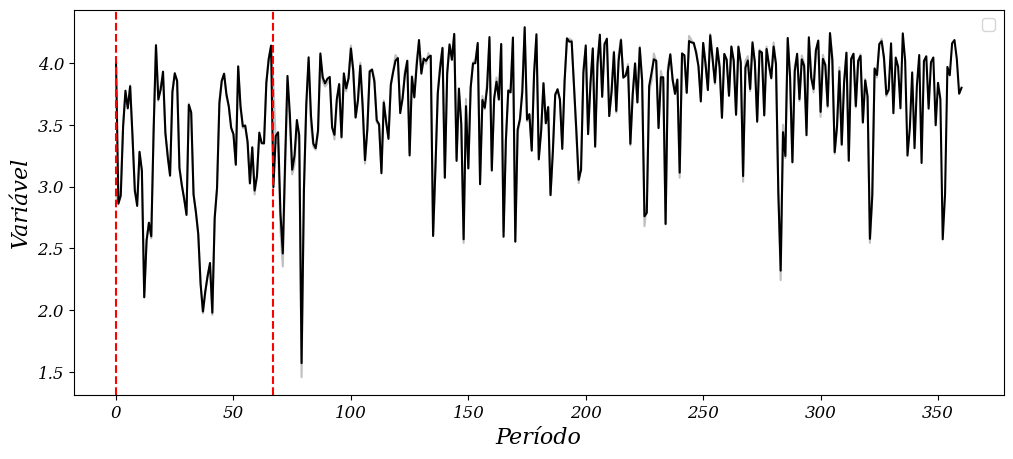

In [80]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arimax_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


In [81]:

lj_arimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMAX

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAPE Erro: 0.136 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAPE Erro: 0.086 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAPE Erro: 0.142 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAPE Erro: 0.137
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.435 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.302 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.463 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 0.446
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RMSE Erro: 0.596 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RMSE Erro: 0.434 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RMSE Erro: 0.627 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RMSE Erro: 0.601


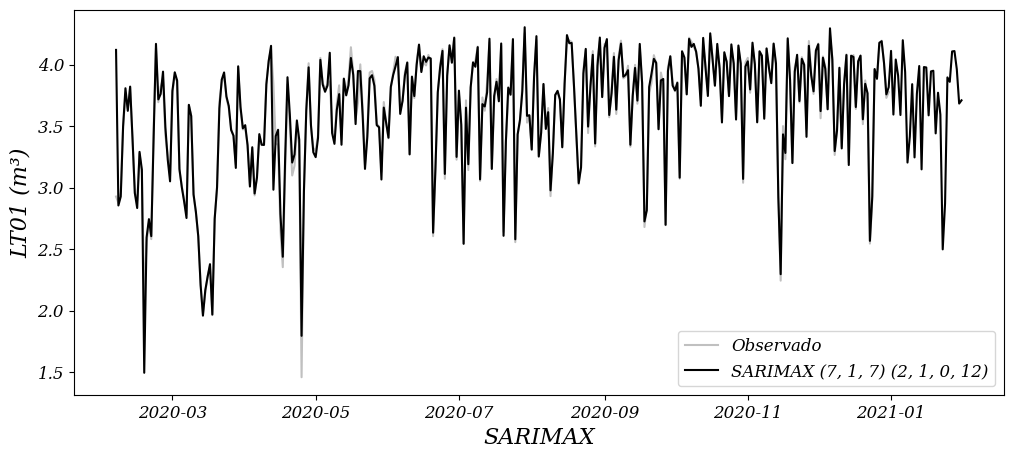

In [82]:

best_model_tst = sr(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)


res_tst = best_model_tst.fit(dis=False)
### Validação



best_model_vld = sr(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_vld = best_model_vld.fit(dis=False)

### Treino

best_model_trn = sr(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_trn = best_model_trn.fit(dis=False)

### DADOS COMPLETO

best_model = sr(endog, 
                     exog, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res = best_model.fit(dis=False)

### Prevendo SARIMAX

sarimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])

sarimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])

sarimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])

sarimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])



### Erros SARIMAX

mape_sarimax_trn = mean_absolute_percentage_error(endog_trn, sarimax_trn[pv+1:])
mape_sarimax_vld = mean_absolute_percentage_error(endog_vld, sarimax_vld[pv+1:])
mape_sarimax_tst = mean_absolute_percentage_error(endog_tst, sarimax_tst[pv+1:])
sarimax_mape = mean_absolute_percentage_error(endog, sarimax[pv+1:])

mae_sarimax_trn = mean_absolute_error(endog_trn, sarimax_trn[pv+1:])
mae_sarimax_vld = mean_absolute_error(endog_vld, sarimax_vld[pv+1:])
mae_sarimax_tst = mean_absolute_error(endog_tst, sarimax_tst[pv+1:])
sarimax_mae = mean_absolute_error(endog, sarimax[pv+1:])

rmse_sarimax_trn = mean_squared_error(endog_trn, sarimax_trn[pv+1:], squared = False)
rmse_sarimax_vld = mean_squared_error(endog_vld, sarimax_vld[pv+1:], squared = False)
rmse_sarimax_tst = mean_squared_error(endog_tst, sarimax_tst[pv+1:], squared = False)
sarimax_rmse = mean_squared_error(endog, sarimax[pv+1:], squared = False)


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAPE Erro: {sarimax_mape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RMSE Erro: {sarimax_rmse:2.3f}")


# Visualiza previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarimax_tst, 'black')
plt.ylabel(rt , fontsize = 16)
plt.xlabel(f'SARIMAX', fontsize = 16)
plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv}-SARIMAX.pdf", dpi=500)
plt.show()

# Anomalias SARIMAX

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Índices das anomalias encontradas: [ 0 12 67 79]


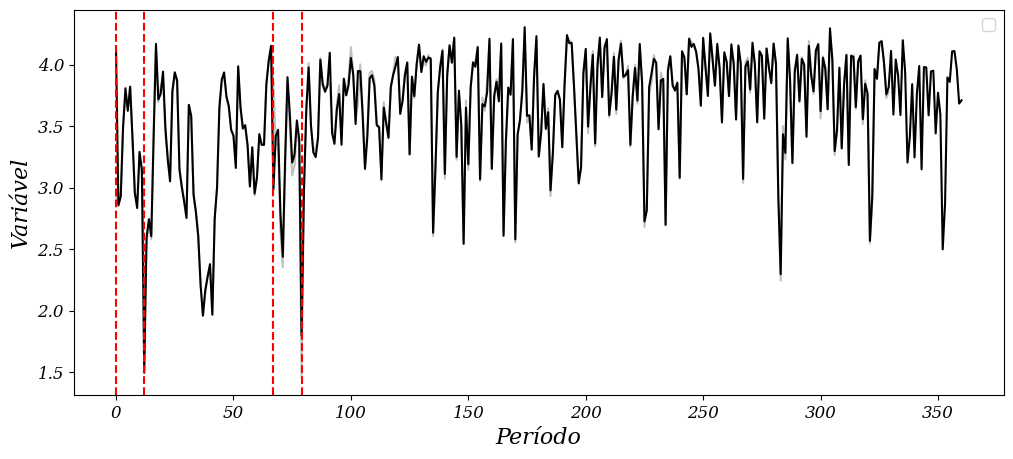

In [83]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(sarimax_tst), 'black')
plt.ylabel('Variável', fontsize=16)
plt.xlabel('Período', fontsize=16)

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]
#plt.plot(anomaly_indices, anomaly_values, color='red', linestyle='-', label='Anomalias')

# anomaly_indices = [i for i in range(len(df) - pv - 1, len(df) + pv) if i in anomalies]
# plt.scatter(anomaly_indices, endog_tst[anomaly_indices], c='red', marker='o', s=50, label='Anomalias')
# plt.legend()

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


In [84]:

lj_sarimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Comparação dos modelos ARIMA

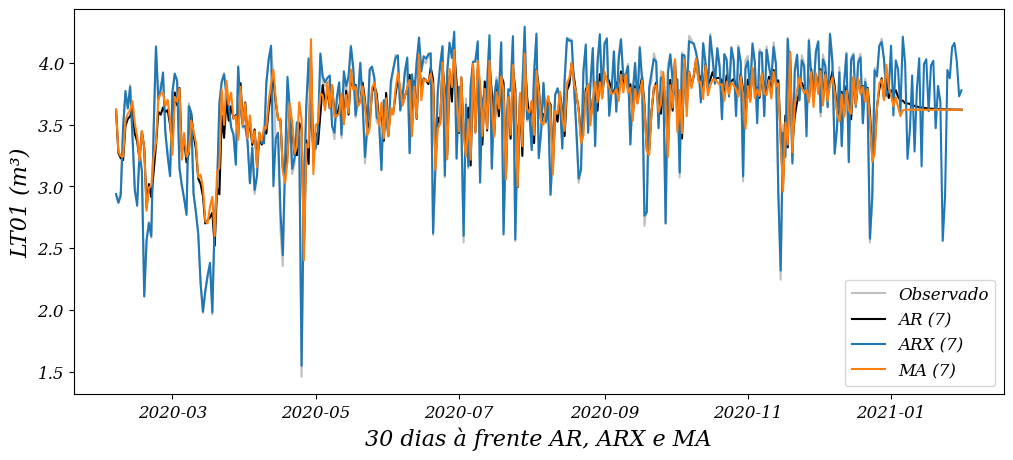

In [85]:
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_tst, 'black')
plt.plot(arx_tst)
plt.plot(ma_tst)


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv}-AR-ARX-MA.pdf", dpi=500)
plt.show()

In [86]:
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(ar_tst), 'black')
# plt.plot(list(arx_tst), 'red')
# plt.plot(list(ma_tst), 'yellow')


# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
# plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA {q1}'])
# plt.savefig(f"{pv}-AR-ARX-MA.png", dpi=300)
# plt.show()

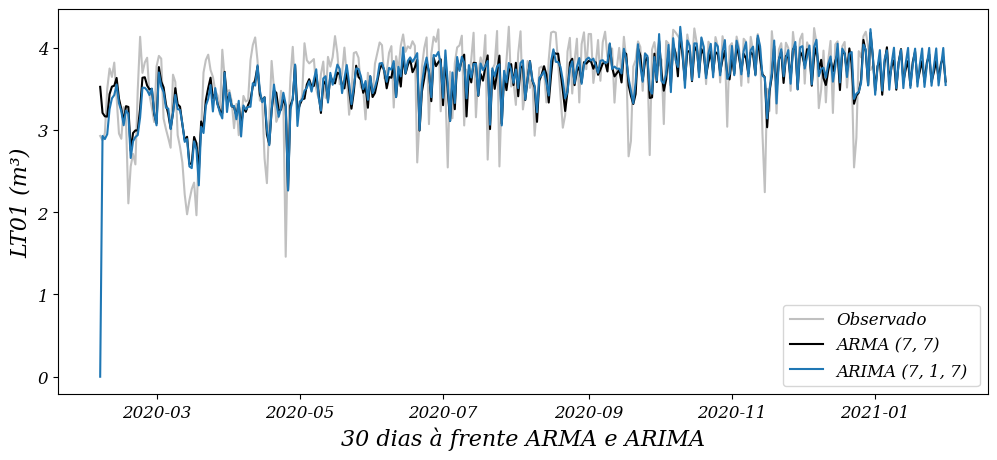

In [87]:


plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_tst, 'black')
plt.plot(arima_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv}-ARMA-ARIMA.pdf", dpi=500)
plt.show()


In [88]:


# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(arma_tst), 'black')
# plt.plot(list(arima_tst), 'red')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+'ARMA e ARIMA', fontsize = 16)
# plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
# plt.savefig(f"{pv}-ARMA-ARIMA.png", dpi=300)
# plt.show()


In [89]:

# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(sarima_tst), 'black')
# plt.plot(list(sarimax_tst), 'red')
# plt.plot(list(arimax_tst), 'yellow')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
# f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.png", dpi=300)
# plt.show()

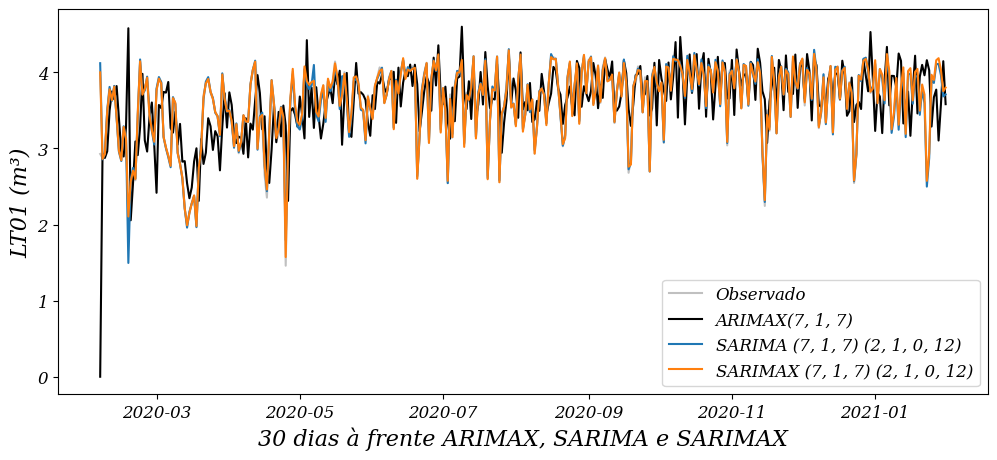

In [90]:

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_tst, 'black')
plt.plot(sarimax_tst)
plt.plot(arimax_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.pdf", dpi=500)
plt.show()

## Regressão

[16:42:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:42:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:42:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:42:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

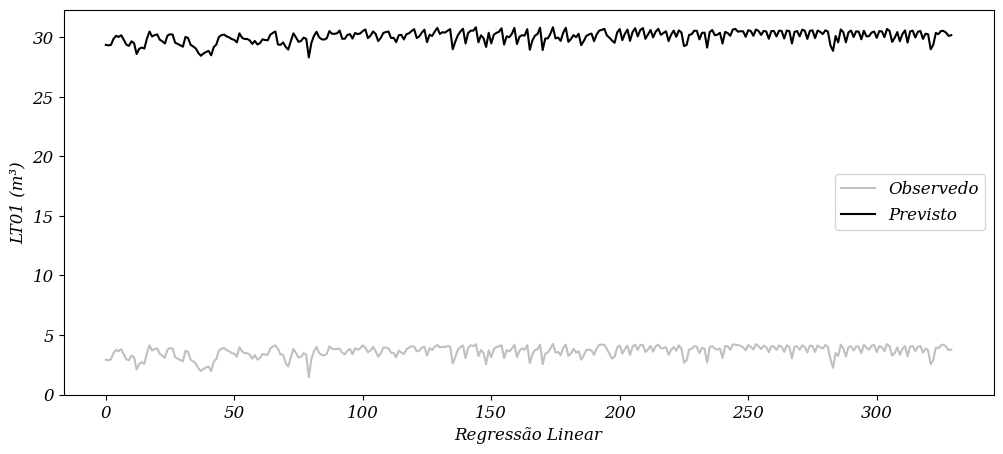

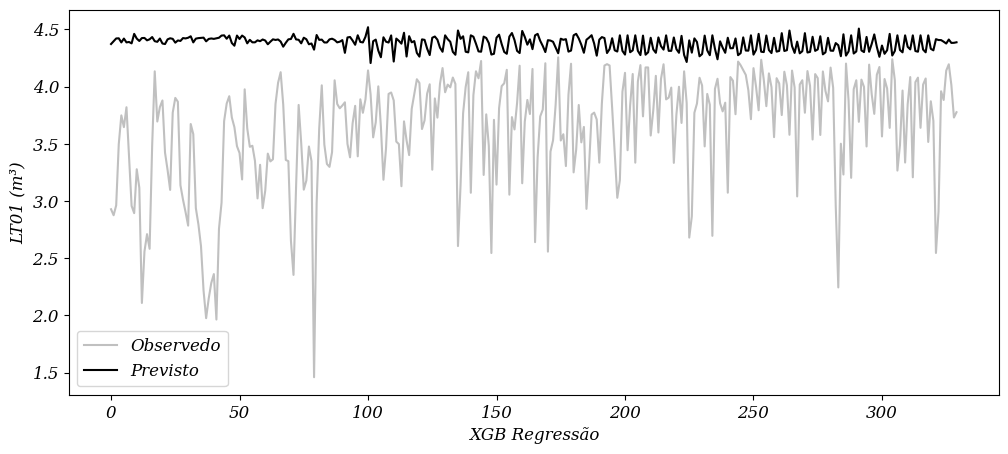

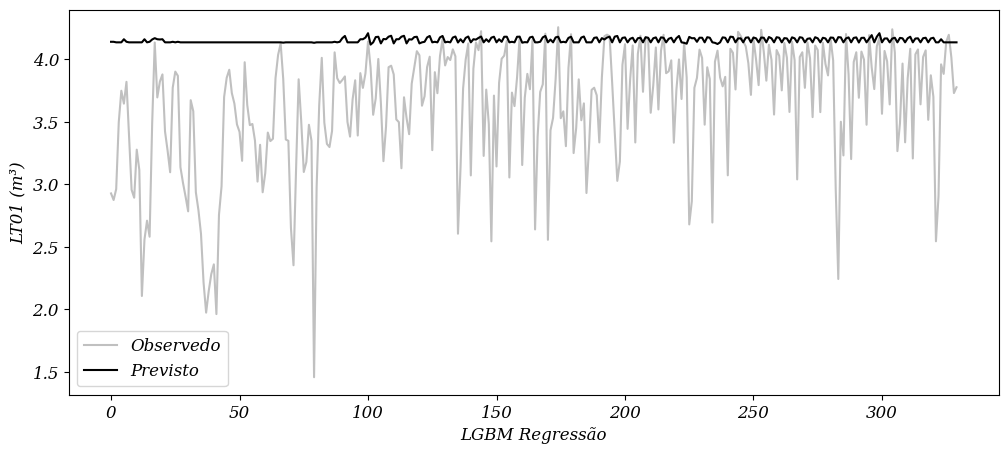

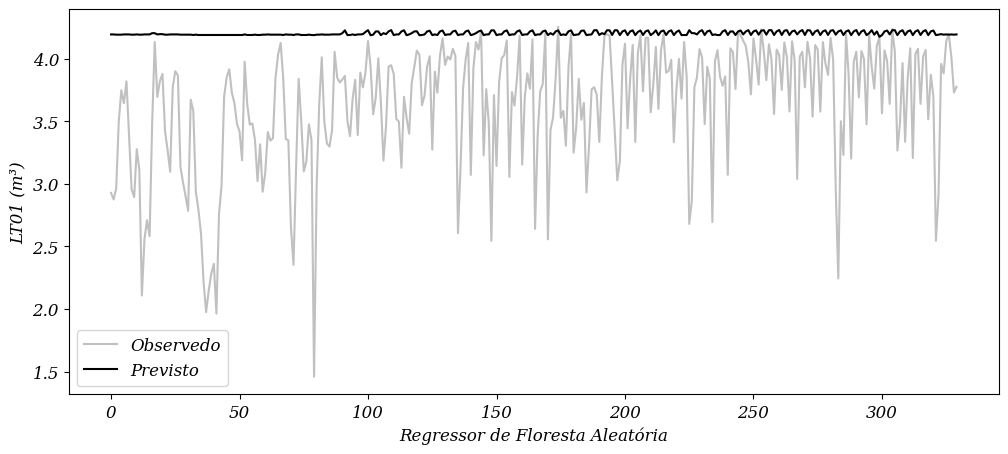

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_trn = lm_trn.predict(endog_l_trn+pv)
lr_vld = lm_vld.predict(endog_l_vld+pv)
lr_tst = lm_tst.predict(endog_l_tst+pv)
lr = lm_tst.predict(endog_l+pv)

random.seed(0)

# my_xgb = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
#              grow_policy='depthwise', importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
#              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
#              max_depth=14, max_features='log2', max_leaves=0,
#              min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
#              monotone_constraints='()', n_estimators=800)

my_xgb = XGBRegressor(bootstrap = True, max_depth = 2, max_features = 'auto', min_samples_leaf = 2,
                       min_samples_split = 2, n_estimators = 5650)

# my_xgb = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb.fit(X = exog_vld, y = endog_vld)
x = my_xgb.fit(X = exog, y = endog)
xgb_trn = x_trn.predict(exog_trn+pv)
xgb_vld = x_vld.predict(exog_vld+pv)
xgb_tst = x_tst.predict(exog_tst+pv)
xgb = x.predict(exog+pv)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
#               min_samples_leaf=2, min_samples_split=2)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=14, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
       'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
       'degree': Integer(1,8),
       'kernel': Categorical(['linear', 'poly', 'rbf']),
       "bootstrap": Categorical([True, False]), 
        "max_depth": Integer(6, 40), 
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 30),
        "min_samples_split": Integer(2,20),
        "n_estimators": Integer(50, 200)
    }



my_lgbm = BayesSearchCV(LGBMRegressor(), search_space, 
       n_iter=32, verbose=True, cv=4,
       random_state=122)
lb_trn = my_lgbm.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm.fit(X = exog, y = endog)
lgbm_trn = lb_trn.predict(exog_trn+pv)
lgbm_vld = lb_vld.predict(exog_vld+pv)
lgbm_tst = lb_tst.predict(exog_tst+pv)
lgbm = lb.predict(exog+pv)

# my_rf = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf = RandomForestRegressor()

# my_rf = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf = my_rf.fit(X = exog_trn, y = endog_trn)
tst_rf = my_rf.fit(X = exog_tst, y = endog_tst)
vld_rf = my_rf.fit(X = exog_vld, y = endog_vld)
rf = my_rf.fit(X = exog, y = endog)
rf_trn = trn_rf.predict(exog_trn+pv)
rf_vld = vld_rf.predict(exog_vld+pv)
rf_tst = tst_rf.predict(exog_tst+pv)
rf_df = rf.predict(exog+pv)

### Erros LR

mape_lr_trn = mean_absolute_percentage_error(endog_l_trn, lr_trn)
mape_lr_vld = mean_absolute_percentage_error(endog_l_vld, lr_vld)
mape_lr_tst = mean_absolute_percentage_error(endog_l_tst, lr_tst)
mape_lr = mean_absolute_percentage_error(endog_l, lr)


mae_lr_trn = mean_absolute_error(endog_l_trn, lr_trn)
mae_lr_vld = mean_absolute_error(endog_l_vld, lr_vld)
mae_lr_tst = mean_absolute_error(endog_l_tst, lr_tst)
mae_lr = mean_absolute_error(endog_l, lr)

rmse_lr_trn = mean_squared_error(endog_l_trn, lr_trn, squared = False)
rmse_lr_vld = mean_squared_error(endog_l_vld, lr_vld, squared = False)
rmse_lr_tst = mean_squared_error(endog_l_tst, lr_tst, squared = False)
rmse_lr = mean_squared_error(endog_l, lr, squared = False)

### Erros xgb

mape_xgb_trn = mean_absolute_percentage_error(endog_trn, xgb_trn)
mape_xgb_tst = mean_absolute_percentage_error(endog_tst, xgb_tst)
mape_xgb_vld = mean_absolute_percentage_error(endog_vld, xgb_vld)
mape_xgb = mean_absolute_percentage_error(endog, xgb)

mae_xgb_trn = mean_absolute_error(endog_trn, xgb_trn)
mae_xgb_tst = mean_absolute_error(endog_tst, xgb_tst)
mae_xgb_vld = mean_absolute_error(endog_vld, xgb_vld)
mae_xgb = mean_absolute_error(endog, xgb)

rmse_xgb_trn = mean_squared_error(endog_trn, xgb_trn, squared = False)
rmse_xgb_tst = mean_squared_error(endog_tst, xgb_tst, squared = False)
rmse_xgb_vld = mean_squared_error(endog_vld, xgb_vld, squared = False)
rmse_xgb = mean_squared_error(endog, xgb, squared = False)

### Erros lgbm

mape_lgbm_trn = mean_absolute_percentage_error(endog_trn, lgbm_trn)
mape_lgbm_tst = mean_absolute_percentage_error(endog_tst, lgbm_tst)
mape_lgbm_vld = mean_absolute_percentage_error(endog_vld, lgbm_vld)
mape_lgbm = mean_absolute_percentage_error(endog, lgbm)

mae_lgbm_trn = mean_absolute_error(endog_trn, lgbm_trn)
mae_lgbm_tst = mean_absolute_error(endog_tst, lgbm_tst)
mae_lgbm_vld = mean_absolute_error(endog_vld, lgbm_vld)
mae_lgbm = mean_absolute_error(endog, lgbm)

rmse_lgbm_trn = mean_squared_error(endog_trn, lgbm_trn, squared = False)
rmse_lgbm_tst = mean_squared_error(endog_tst, lgbm_tst, squared = False)
rmse_lgbm_vld = mean_squared_error(endog_vld, lgbm_vld, squared = False)
rmse_lgbm = mean_squared_error(endog, lgbm, squared = False)


### Erros rf

mape_rf_trn = mean_absolute_percentage_error(endog_trn, rf_trn)
mape_rf_tst = mean_absolute_percentage_error(endog_tst, rf_tst)
mape_rf_vld = mean_absolute_percentage_error(endog_vld, rf_vld)
mape_rf = mean_absolute_percentage_error(endog, rf_df)

mae_rf_trn = mean_absolute_error(endog_trn, rf_trn)
mae_rf_tst = mean_absolute_error(endog_tst, rf_tst)
mae_rf_vld = mean_absolute_error(endog_vld, rf_vld)
mae_rf = mean_absolute_error(endog, rf_df)

rmse_rf_trn = mean_squared_error(endog_trn, rf_trn, squared = False)
rmse_rf_tst = mean_squared_error(endog_tst, rf_tst, squared = False)
rmse_rf_vld = mean_squared_error(endog_vld, rf_vld, squared = False)
rmse_rf = mean_squared_error(endog, rf_df, squared = False)

print(  f"Regressão linear  MAPE Erro: {mape_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr:2.3f} ",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr:2.3f} ",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_tst:2.3f} Test",'\n','\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb:2.3f} ",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb:2.3f} ",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb:2.3f} ",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm:2.3f} ",'\n'
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_tst:2.3f} Test")

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lr_tst), 'black')
plt.xlabel('Regressão Linear')
plt.legend(['Observedo','Previsto'])
plt.savefig(f"{pv}-regressão-linear.pdf", dpi=500)
plt.ylabel(rt)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(xgb_tst), 'black')
plt.xlabel('XGB Regressão')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"{pv}-xgb-regressão.pdf", dpi=500)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lgbm_tst), 'black')
plt.xlabel('LGBM Regressão')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"{pv}-lgbm-regressão.pdf", dpi=500)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(rf_tst), 'black')
plt.xlabel('Regressor de Floresta Aleatória')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"{pv}-regressão-rfa.pdf", dpi=500)
plt.show()

In [92]:
# my_lm = LinearRegression()
# lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
# lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
# lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
# lm = my_lm.fit(X =endog_l, y = endog)
# lr_trn = lm_trn.predict(endog_l_trn+pv)
# lr_vld = lm_vld.predict(endog_l_vld+pv)
# lr_tst = lm_tst.predict(endog_l_tst+pv)
# lr = lm_tst.predict(endog_l+pv)

# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.scatter(endog_l_tst, endog_tst, color = 'black')
# plt.plot(endog_l_tst, lr_tst, 'b')
# plt.xlabel(f'{rt}',fontsize = 16)
# plt.ylabel(f'PT01 m³/h',fontsize = 16)
# plt.savefig(f"LR {rt}.png", dpi=1000)
# plt.show()



Coeficiente R²: 0.3062


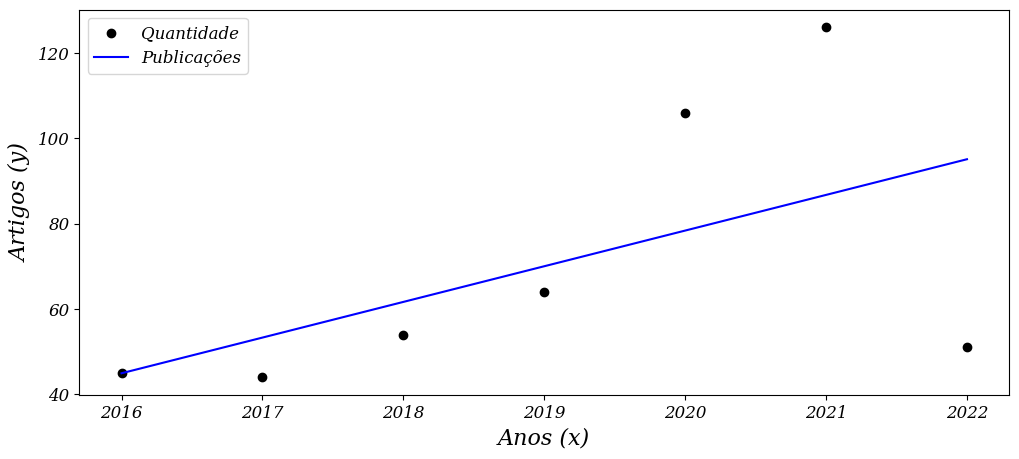

In [93]:
rg = pd.read_csv('regressão linear.csv', sep = ';')
# rg.set_index('Ano', inplace = True)

X = rg[['Ano']]
Y = rg['quantidade de artigo']

rg1 = my_lm.fit(X, Y)
reg = rg1.predict(X)

r_squared = r2_score(Y, reg)
print(f'Coeficiente R²: {r_squared:2.4f}')

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(X, Y, color = 'black')
plt.plot(X, reg, 'b')
plt.xlabel('Anos (x)',fontsize = 16)
plt.ylabel('Artigos (y)',fontsize = 16)
plt.legend(['Quantidade', 'Publicações'], loc='upper left')
plt.savefig("regressão linear dos artigos baseados nos anos.pdf", dpi=500)
plt.show()

# Optuna

In [94]:
# import optuna

# def objective(trial):
#     x = trial.suggest_float('x', -10, 10)
#     return (x - 2) ** 2

# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# study.best_params  # E.g. {'x': 2.002108042}

In [95]:
# opt = BayesSearchCV(
#     XGBRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,20),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=52,
#        random_state=0)
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [96]:
# opt = XGBRegressor()
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [97]:

# opt.fit(exog_trn, endog_trn)

In [98]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [99]:
# from sklearn.model_selection import RandomizedSearchCV

# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(XGBRegressor(), param_space, n_iter=32,
#                                         scoring="accuracy", verbose=True, cv=5,
#                                         n_jobs=-1, random_state=42)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

# Grid

In [100]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     

# forest_clf = XGBRegressor()

# opt = GridSearchCV(my_xgb, param_grid, cv=30,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

# # melhor otimização xgb


In [101]:
# print(opt.best_params_)


In [102]:
# print(opt.best_estimator_)


In [103]:
# print(opt.best_score_)

In [104]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     


# opt = GridSearchCV(my_lgbm, param_grid, cv=30,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100


In [105]:
# print(opt.best_params_)

In [106]:
# print(opt.best_estimator_)

In [107]:
# print(opt.best_score_)

In [108]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     



# opt = GridSearchCV(my_rf, param_grid, cv=6,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100


In [109]:
# print(opt.best_params_)

In [110]:
# print(opt.best_estimator_)

In [111]:
# print(opt.best_score_)

# Randomizer

In [112]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_xgb, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [113]:
# print(opt.best_params_)


In [114]:
# print(opt.best_estimator_)


In [115]:
# print(opt.best_score_)


In [116]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_lgbm, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)

In [117]:
# print(opt.best_params_)

In [118]:
# print(opt.best_estimator_)

In [119]:
# print(opt.best_score_*100)

In [120]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_rf, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)

# #melhor otimização rf


In [121]:
# print(opt.best_params_)


In [122]:
# print(opt.best_estimator_)


In [123]:
# print(opt.best_score_)


# Bayes

In [124]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [125]:

# search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        "bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(5, 200)
#        }

# opt = BayesSearchCV(my_xgb, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [126]:

# search_space = {"bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_xgb, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [127]:

# search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        "bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_lgbm, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [128]:

# search_space = {"bootstrap": Categorical([True, False]), 
#        "max_depth": Integer(6, 40), 
#        "max_features": Categorical(['auto', 'sqrt','log2']), 
#        "min_samples_leaf": Integer(2, 30),
#        "min_samples_split": Integer(2,20),
#        "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_rf, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


# Cross Validation

In [129]:
# crv(my_xgb, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [130]:
# crv(my_lgbm, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [131]:
# crv(my_lm, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [132]:
# crv(my_rf, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

#  Comparação Modelos Violino

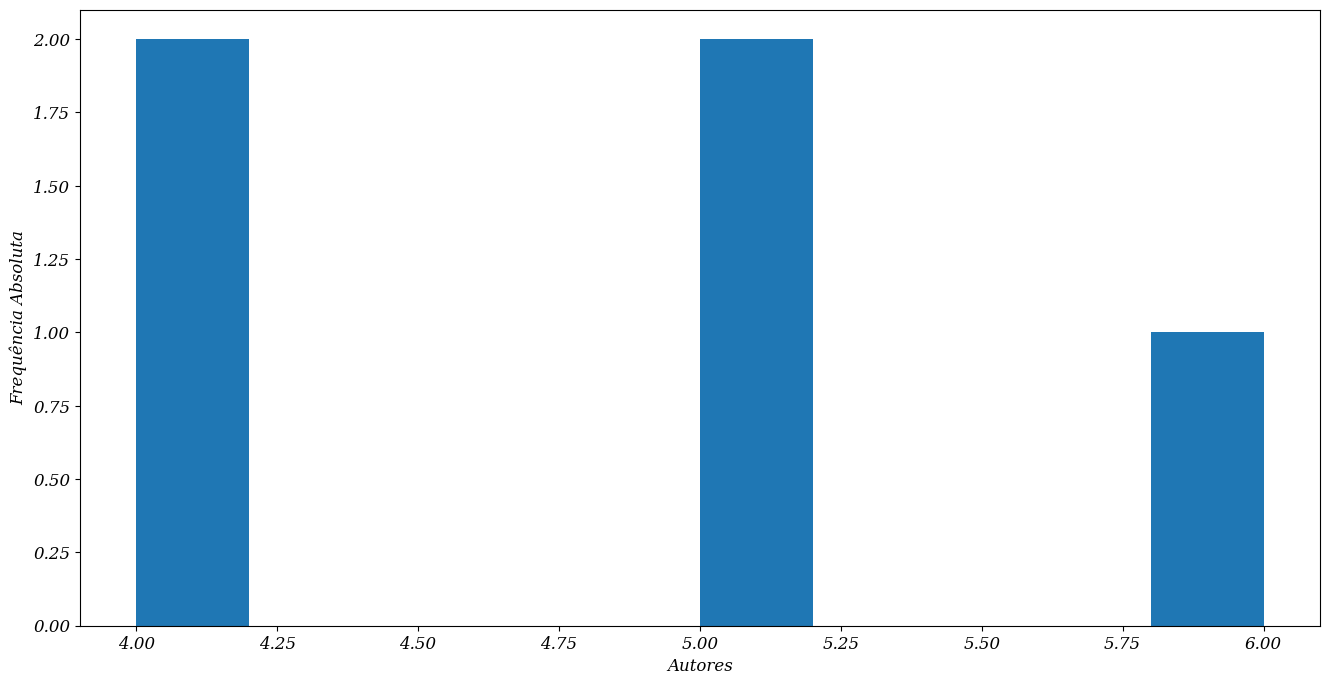

In [133]:
artigos=[6,5,5,4,4]
plt.xlabel('Autores')
plt.ylabel('Frequência Absoluta')
plt.hist(artigos)
plt.show()

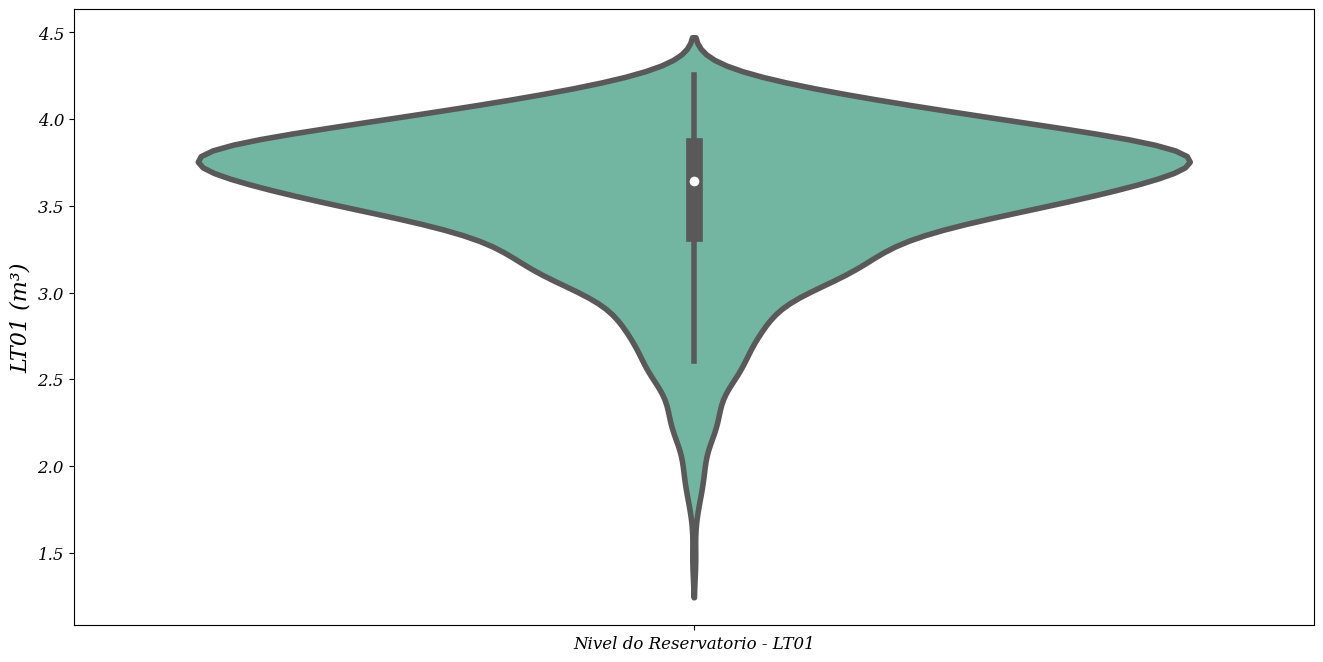

In [134]:
sns.violinplot(data = df['NIVEL DO RESERVATÓRIO - LT01'], linewidth = 4, palette="Set2")
x = [0]
labels = ['Nivel do Reservatorio - LT01']

plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.savefig(f"viol.pdf", dpi=500)
plt.show()

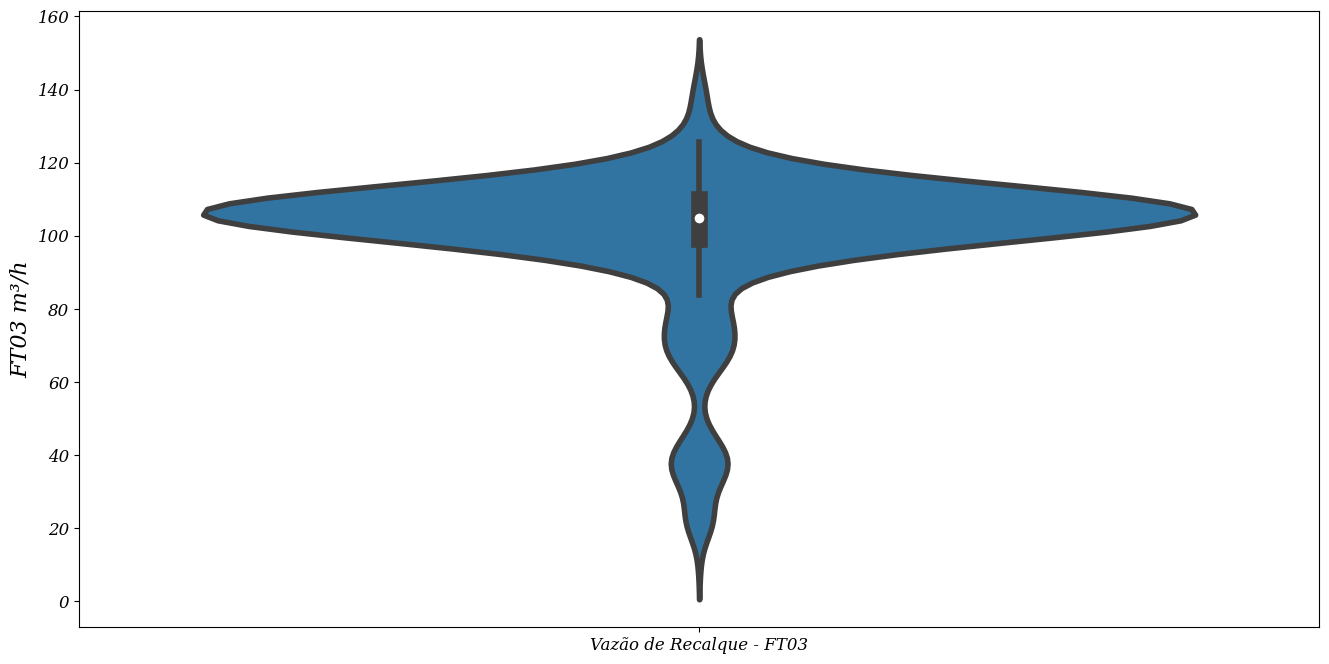

In [135]:
sns.violinplot(data = df['VAZÃO DE RECALQUE - FT03'],linewidth = 4)
x = [0]
labels = ['Vazão de Recalque - FT03']
plt.xticks(x, labels)
plt.ylabel('FT03 m³/h' , fontsize = 16)
plt.savefig(f"ft03.pdf", dpi=500)
plt.show()

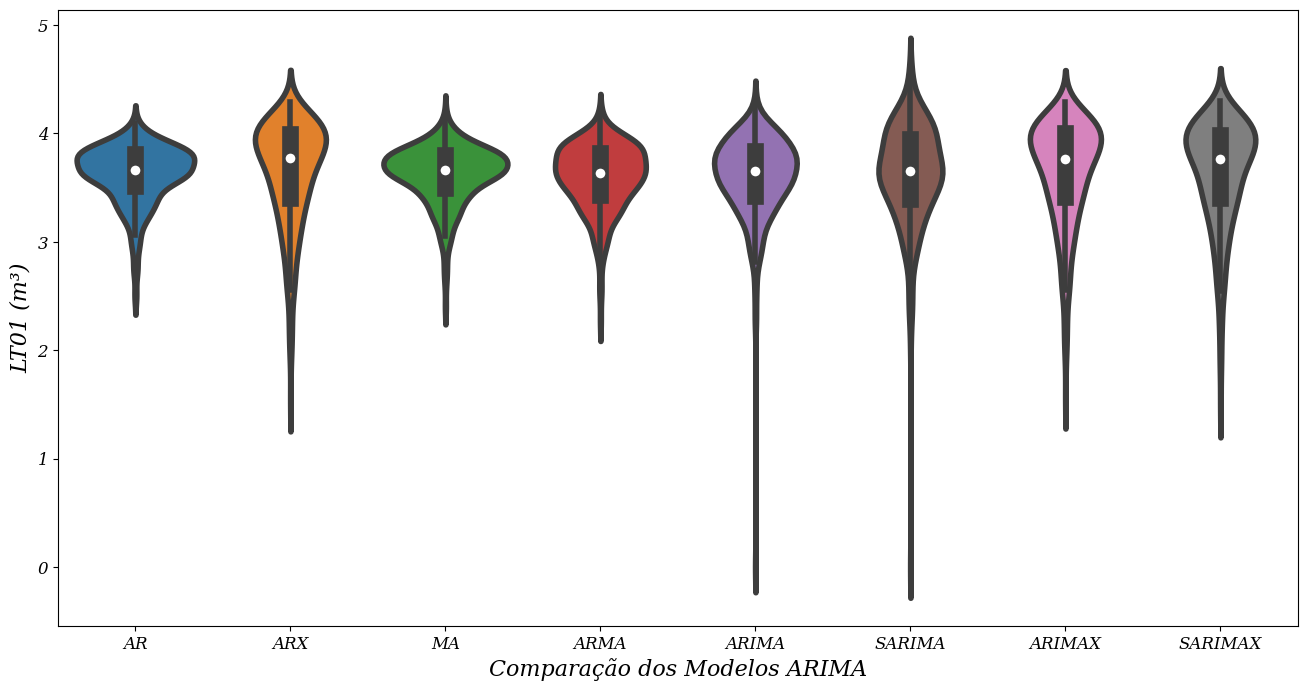

In [136]:
sns.violinplot(data = [ar_tst, arx_tst, ma_tst, arma_tst, arima_tst, sarima_tst, arimax_tst, sarimax_tst], 
               linewidth = 4)
x = [0,1,2,3,4,5,6,7]
labels = ['AR', 'ARX', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX']
plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.xlabel('Comparação dos Modelos ARIMA', fontsize = 16)
plt.savefig(f"{pv}-modelos-arima.pdf", dpi=500)
plt.show()

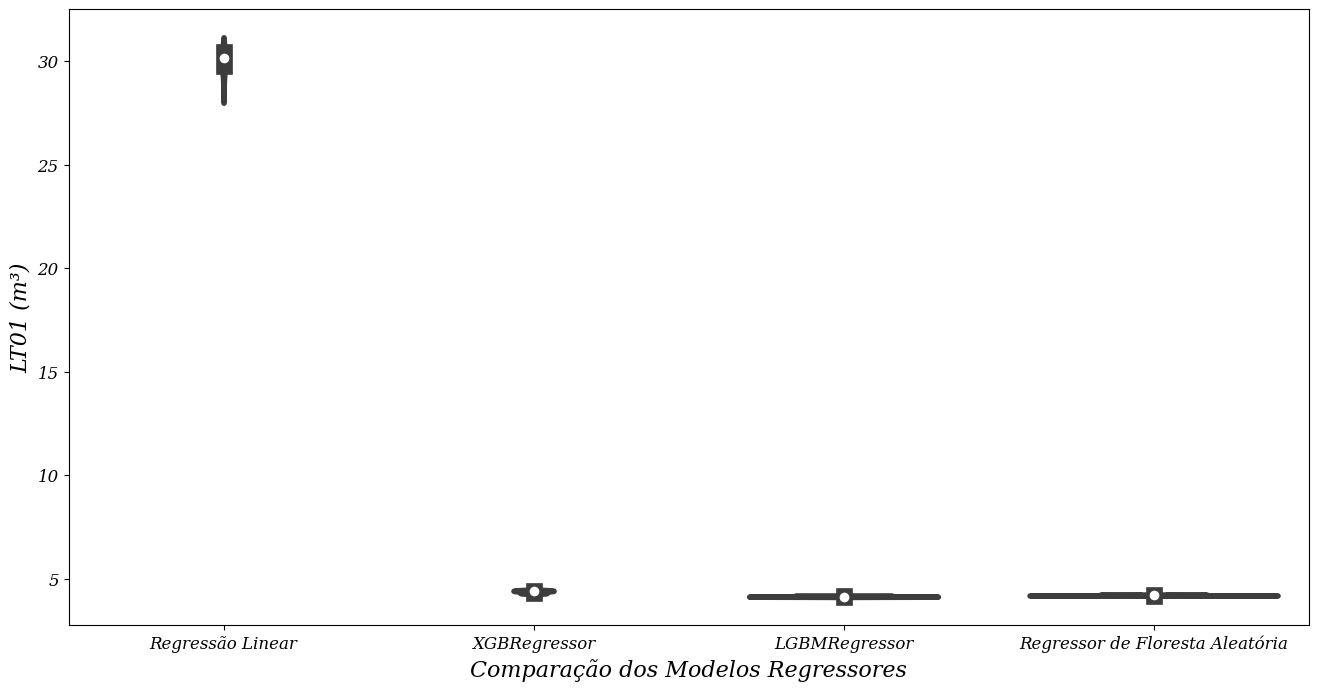

In [137]:
sns.violinplot(data = [lr_tst, xgb_tst, lgbm_tst, rf_tst], linewidth = 4)
x = [0,1,2,3]
labels = ['Regressão Linear', 'XGBRegressor', 'LGBMRegressor', 'Regressor de Floresta Aleatória']
plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.xlabel('Comparação dos Modelos Regressores', fontsize = 16)
plt.savefig(f"{pv}-violin-LR-XGB-LGBM-RF.pdf", dpi=500)
plt.show()

#  Comparação regressão 

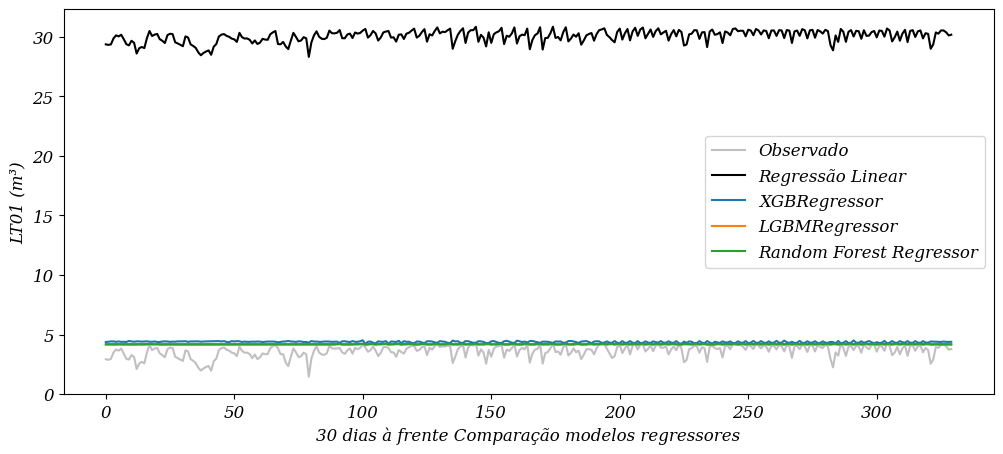

In [138]:
# x = range(0,len(endog_tst),50)
# value = endog_tst.index[range(0,len(endog_tst),50)]
plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lr_tst), 'black')
plt.plot(list(xgb_tst))
plt.plot(list(lgbm_tst))
plt.plot(list(rf_tst))
# plt.yticks(fontsize = 12)
# plt.xticks(x, value, fontsize = 10)
plt.xlabel(pvl+' Comparação modelos regressores', fontsize = 12)
plt.legend(['Observado','Regressão Linear', 'XGBRegressor', 'LGBMRegressor', 'Random Forest Regressor'])
plt.ylabel(rt)
plt.savefig(f"{pv}-LR-XGB-LGBM-RF.pdf", dpi=500)
plt.show()

# Redes neurais

## LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1200)              5769600   
                                                                 
 dense (Dense)               (None, 613)               736213    
                                                                 
Total params: 6,505,813
Trainable params: 6,505,813
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
16/16 [==============================] - 7s 120ms/step - loss: 1.4995 - mean_absolute_error: 1.4995 - val_loss: 0.6860 - val_mean_absolute_error: 0.6860
Epoch 2/5
16/16 [==============================] - 1s 74ms/step - loss: 0.3796 - mean_absolute_error: 0.3796 - val_loss: 0.1800 - val_mean_absolute_error: 0.1800
Epoch 3/5
16/16 [==============================] - 1s 80ms/step - loss: 0.1925 - mean_absolute_error: 0.1925 - val_lo

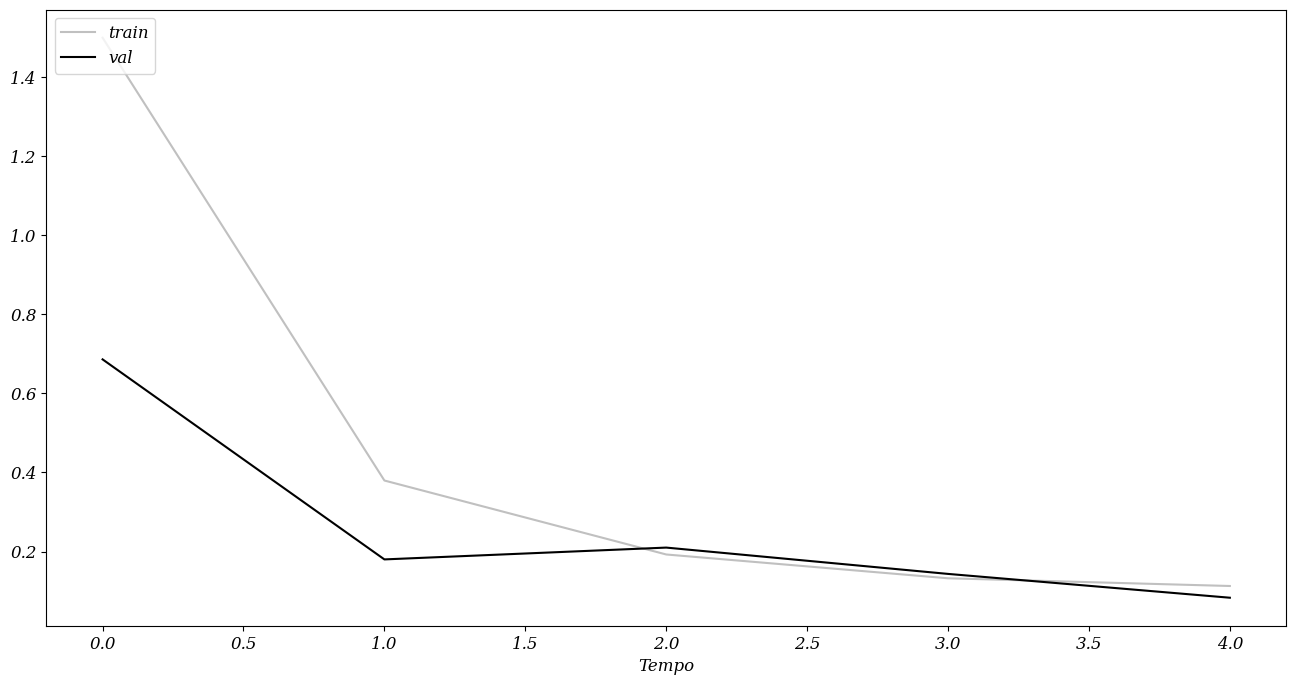

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

n_samples = endog_trn.shape[0]
n_timesteps = endog_trn.shape[0]
n_steps = endog_trn.shape[0]
n_features = 1

# endog_trn_rs = endog_trn.reshape(n_samples, n_timesteps, n_features )
# endog_tst_rs = endog_tst.reshape(endog_tst.shape[0], n_timesteps, n_features )

random.seed(42)
batch_size = 32
simple_model = Sequential([LSTM(1200, activation='tanh',input_shape=(n_timesteps, n_features)),Dense(endog_trn.shape[0])])
simple_model.summary()
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(endog_trn, endog_trn,
                                validation_split=0.2,
                                epochs=5,
                                batch_size=batch_size,
                                shuffle = True)
                                
preds = simple_model.predict(endog_tst+pv)
# print(mean_absolute_error(preds, endog_tst))
plt.plot(smod_history.history['loss'], 'silver')
plt.plot(smod_history.history['val_loss'], 'black')
plt.xlabel('Tempo')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




# Salva Erro


In [140]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'MAPE':[ mape_AR_trn, mape_ARX_trn, mape_MA_trn ,mape_ARMA_trn, 
        mape_ARIMA_trn,mape_SARIMA_trn, mape_arimax_trn,mape_sarimax_trn, mape_lr_trn, mape_rf_trn, mape_xgb_trn, 
        mape_lgbm_trn],
        'MAE':[ mae_AR_trn, mae_ARX_trn, mae_MA_trn, mae_ARMA_trn,mae_ARIMA_trn,
        mae_SARIMA_trn, mae_arimax_trn, mae_sarimax_trn, mae_lr_trn, mae_rf_trn, mae_xgb_trn, mae_lgbm_trn],
        'RMSE':[ rmse_AR_trn, rmse_ARX_trn, rmse_MA_trn, rmse_ARMA_trn,rmse_ARIMA_trn,
        rmse_SARIMA_trn,rmse_arimax_trn, rmse_sarimax_trn, rmse_lr_trn, rmse_rf_trn, rmse_xgb_trn, rmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
sarimax_erro


MAPE    MAE   RMSE
AR                      0.121  0.383  0.514
ARX                     0.135  0.432  0.592
MA                      0.120  0.379  0.510
ARMA                    0.120  0.383  0.508
ARIMA                   0.124  0.395  0.527
SARIMA                  0.126  0.405  0.538
ARIMAX                  0.136  0.434  0.594
SARIMAX                 0.136  0.435  0.596
Linear Regression       5.827 25.483 25.484
Random Forest Regressor 0.224  0.704  0.820
XGBRegressor            0.282  0.902  0.998
LGBMRegressor           0.211  0.659  0.780

In [141]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'MAPE':[ mape_AR_vld, mape_ARX_vld, mape_MA_vld, mape_ARMA_vld,mape_ARIMA_vld,
        mape_SARIMA_vld,mape_arimax_vld, mape_sarimax_vld, mape_lr_vld, mape_rf_vld, mape_xgb_vld, mape_lgbm_vld],
        'MAE':[ mae_AR_vld, mae_ARX_vld, mae_MA_vld, mae_ARMA_vld,mae_ARIMA_vld,
        mae_SARIMA_vld, mae_arimax_vld, mae_sarimax_vld, mae_lr_vld, mae_rf_vld, mae_xgb_vld, mae_lgbm_vld],
        'RMSE':[rmse_AR_vld, rmse_ARX_vld, rmse_MA_vld, rmse_ARMA_vld,rmse_ARIMA_vld,
        rmse_SARIMA_vld,rmse_arimax_vld, rmse_sarimax_vld, rmse_lr_vld, rmse_rf_vld, rmse_xgb_vld, rmse_lgbm_vld],
    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
sarimax_erro


MAPE    MAE   RMSE
AR                      0.091  0.311  0.390
ARX                     0.086  0.302  0.434
MA                      0.090  0.306  0.383
ARMA                    0.089  0.304  0.384
ARIMA                   0.100  0.343  0.426
SARIMA                  0.098  0.337  0.412
ARIMAX                  0.086  0.301  0.433
SARIMAX                 0.086  0.302  0.434
Linear Regression       5.721 25.478 25.478
Random Forest Regressor 0.187  0.626  0.708
XGBRegressor            0.245  0.831  0.896
LGBMRegressor           0.174  0.580  0.666

In [142]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {   
      
        'MAPE': [mape_AR_tst, mape_ARX_tst, mape_MA_tst, mape_ARMA_tst,mape_ARIMA_tst,
        mape_SARIMA_tst,mape_arimax_tst, mape_sarimax_tst, mape_lr_tst, mape_rf_tst, mape_xgb_tst, mape_lgbm_tst],
        'MAE': [mae_AR_tst, mae_ARX_tst, mae_MA_tst, mae_ARMA_tst,mae_ARIMA_tst,
        mae_SARIMA_tst, mae_arimax_tst, mae_sarimax_tst, mae_lr_tst, mae_rf_tst, mae_xgb_tst, mae_lgbm_tst],
        'RMSE':[rmse_AR_tst, rmse_ARX_tst, rmse_MA_tst, rmse_ARMA_tst,rmse_ARIMA_tst,
        rmse_SARIMA_tst,rmse_arimax_tst,rmse_sarimax_tst, rmse_lr_tst, rmse_rf_tst, rmse_xgb_tst, rmse_lgbm_tst],
    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros teste.xlsx')
sarimax_erro


MAPE    MAE   RMSE
AR                      0.117  0.375  0.495
ARX                     0.141  0.462  0.628
MA                      0.120  0.384  0.504
ARMA                    0.118  0.384  0.496
ARIMA                   0.120  0.390  0.509
SARIMA                  0.132  0.431  0.570
ARIMAX                  0.140  0.459  0.627
SARIMAX                 0.142  0.463  0.627
Linear Regression       5.663 25.466 25.466
Random Forest Regressor 0.188  0.581  0.756
XGBRegressor            0.239  0.754  0.918
LGBMRegressor           0.174  0.532  0.716

In [143]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        "MAPE": [AR_mape, ARX_mape, MA_mape, ARMA_mape, ARIMA_mape, SARIMA_mape, arimax_mape, sarimax_mape, mape_lr, mape_rf,
         mape_xgb, mape_lgbm],


        "MAE": [AR_mae, ARX_mae, MA_mae, ARMA_mae, ARIMA_mae, SARIMA_mae, arimax_mae, sarimax_mae, mae_lr, mae_rf, mae_xgb, mae_lgbm],


        'RMSE': [ AR_rmse, ARX_rmse, MA_rmse ,ARMA_rmse, ARIMA_rmse, SARIMA_rmse, arimax_rmse, sarimax_rmse, rmse_lr, rmse_rf, 
        rmse_xgb, rmse_lgbm],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_erro


MAPE    MAE   RMSE
AR                      0.114  0.367  0.237
ARX                     0.137  0.447  0.360
MA                      0.113  0.361  0.477
ARMA                    0.120  0.385  0.508
ARIMA                   0.117  0.375  0.497
SARIMA                  0.124  0.404  0.531
ARIMAX                  0.136  0.443  0.596
SARIMAX                 0.137  0.446  0.601
Linear Regression       5.763 25.477 25.477
Random Forest Regressor 0.208  0.656  0.786
XGBRegressor            0.264  0.847  0.961
LGBMRegressor           0.195  0.610  0.746


# Teste significancia


In [144]:

from scipy import stats

#faça o teste de Friedman
friendma = stats.friedmanchisquare(df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA - FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02'])

print(friendma)

import scikit_posthocs as sp

#combine three groups into one array
data = np.array([df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA - FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02']])

#perform Nemenyi post-hoc test
print(sp.posthoc_nemenyi_friedman(data.T))



FriedmanchisquareResult(statistic=8015.610533599998, pvalue=0.0)
      0     1     2     3     4     5     6     7     8
0 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
1 0.001 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.157
2 0.001 0.001 1.000 0.847 0.001 0.001 0.001 0.001 0.001
3 0.001 0.001 0.847 1.000 0.001 0.001 0.001 0.001 0.001
4 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001 0.001
5 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001
6 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001
7 0.001 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001
8 0.001 0.157 0.001 0.001 0.001 0.001 0.001 0.001 1.000


# Ljung Box

In [145]:
ar1 = str(lj_ar_df)
arx1 = str(lj_arx_df)
ma1 = str(lj_ma_df)
arma1 = str(lj_arma_df)
arima1 = str(lj_arima_df)
arimax1 = str(lj_arimax_df)
sarima1 = str(lj_sarima_df)
sarimax1 = str(lj_sarimax_df)


In [146]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    4.703      0.910
AR                     4.262      0.161
MA                    49.158      0.000
ARMA                  40.490      0.000
ARIMA                 40.490      0.000
SARIMA                40.490      0.000
ARIMAX                60.913      0.000
SARIMAX                5.827      0.830

In [147]:
ar1 = str(lj_ar_trn)
arx1 = str(lj_arx_trn)
ma1 = str(lj_ma_trn)
arma1 = str(lj_arma_trn)
arima1 = str(lj_arima_trn)
arimax1 = str(lj_arimax_trn)
sarima1 = str(lj_sarima_trn)
sarimax1 = str(lj_sarimax_trn)


In [148]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_trn.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    6.297      0.790
AR                     7.125      0.072
MA                    34.340      0.000
ARMA                  11.603      0.313
ARIMA                 13.011      0.223
SARIMA                10.165      0.426
ARIMAX                30.360      0.001
SARIMAX               11.634      0.310

In [149]:
ar1 = str(lj_ar_tst)
arx1 = str(lj_arx_tst)
ma1 = str(lj_ma_tst)
arma1 = str(lj_arma_tst)
arima1 = str(lj_arima_tst)
arimax1 = str(lj_arimax_tst)
sarima1 = str(lj_sarima_tst)
sarimax1 = str(lj_sarimax_tst)


In [150]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_tst.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    0.857      1.000
AR                     7.795      0.649
MA                     7.886      0.640
ARMA                  19.344      0.036
ARIMA                  9.499      0.485
SARIMA                 3.567      0.965
ARIMAX                 0.597      1.000
SARIMAX                3.717      0.959

In [151]:
ar1 = str(lj_ar_vld)
arx1 = str(lj_arx_vld)
ma1 = str(lj_ma_vld)
arma1 = str(lj_arma_vld)
arima1 = str(lj_arima_vld)
arimax1 = str(lj_arimax_vld)
sarima1 = str(lj_sarima_vld)
sarimax1 = str(lj_sarimax_vld)


In [152]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_vld.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    7.468      0.681
AR                     2.428      0.992
MA                     1.387      0.999
ARMA                   5.416      0.862
ARIMA                  4.038      0.946
SARIMA                 4.447      0.925
ARIMAX                 0.021      1.000
SARIMAX                0.044      1.000